# Sedaro Studies Example Notebook 
Demonstrates Sedaro Studies support via the sedaro python client using a Jupyter notebook.

**(REMOVE BEFORE FLIGHT)**
> Task 
Where users can adapt them to do their own studies. It should be obvious where the top level override configuration is done as well as the feedback loop (in the case of the Monte Carlo). The notebooks should demonstrate the ability to run many simulations in parallel.  In the monte carlo case, this will be via batches of N sims that are run and then the results pulled and then another N run depending on feedback loop.
- Public jupyter notebooks for:
    - Wildfire Trade Space Analysis: Battery Size vs. Mass
    - Wildfire Monte Carlo: 
        - Vary uncertainty on:
            - Moment of magnetorquers
            - Mass of reaction wheels
            -  Initial position, velocity, and attitude
            - Vary random seeds of sensors by changing simulation-wide seen
        - To understand uncertainty of average pointing error


# Introduction  
This notebook demonstrates how to use the new Studies support added to Sedaro. 
The core of this support is the new API python client object **SimStudy**.
**SimStudy** will generate and run a series of *SimJobs* in parallel up to account capacity limits. The remaining simjobs will be placed in a queue and will be execute when resources are available. 

Each *SimJob* of a **SimStudy** will set the random seed to a different value in order to generate different output results from the simulation.
The **Overrides** feature takes this a step further by providing a means to adjust any starting value of any model of the simulation using a set of pre-defined functions. In other words, each *SimJob* of a **SimStudy** will run a baseline Scenario branch with model parameters variations in order to observe their effects on performance results.

# Setup
Running this notebook requires the following:
- A Sedaro Account            --> https://www.sedaro.com
- A Sedaro API Token          --> https://www.sedaro.com/#/account
- The Wildfire Demo Branch ID --> login --> select/click or create workspace --> select/click Project: [DEMO] WildFire --> select/click  Repositories: [DEMO] Wildfire Scenarios --> copy main branch ID via clipboard icon (TODO insert screen shot)
- Python 3.10+ installed      --> https://www.python.org
- Jupyter notebook or lab     --> https://jupyter.org

## Pip requirements
Create/activate a python venv if desired

In [ ]:
!python -m venv /path/to/new/virtual/environment

Activate it via this table
| Platform | Shell | Command to activate virtual environment |
| :- | :- | :- |
| POSIX | bash/zsh |  source <venv>/bin/activate |
| | fish |  source <venv>/bin/activate.fish |
| | csh/tcsh |  source <venv>/bin/activate.csh |
| | PowerShell |  <venv>/bin/Activate.ps1 |
| Windows | cmd.exe | C:\> <venv>\Scripts\activate.bat |
| | PowerShell | PS C:\> <venv>\Scripts\Activate.ps1 |

Required python modules:
> replace *python* with *python3* if needed 

In [208]:
!python -m pip install -e sedaro pytest matplotlib pandas sweetviz

zsh:1: command not found: python


or

In [ ]:
!python3.10 -m pip install  sedaro pytest matplotlib pandas sweetviz

Optional module needed by the stats() function if desired 

In [ ]:
!python3.10 -m pip install sweetviz IProgress

Run the following cells to test if all required python modules are installed correctly

In [1]:
import sedaro
import yaml
import json
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# optional
import sweetviz as sv

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Important: Read Before Running

This notebook makes changes to agent and scenario branches indicated in the settings section. Ensure any changes to the target branches are saved prior to running this code. Sedaro recommends committing current changes and creating new branches in the target repositories to avoid loss of work.

This notebook also requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the same directory as this notebook with the following format:

```json
{
    "API_KEY": "<API_KEY>"
}
```

API keys grant full access to your repositories and should never be shared. If you think your API key has been compromised, you can revoke it in the user settings interface on the Sedaro website.



## Sedaro python client setup
Note: More information about the sedaro-python client can be found here: [https://github.com/sedaro/sedaro-python]


In the next cell, adjust the following variables as needed
- *Sedaro_api_host*
- *Sedaro_api_token*

In [3]:
Sedaro_api_host  = "http://localhost:80" # "api.sedaro.com"

# Set your API token value either directly or via loading a secrets file
# !! NOTE !!  Be careful not to check in your API Key into a source control repo  !! Note !!
secretPath = '/Users/sedaro/Documents/sedaro/sedaro-satellite/secrets.json'
with open(secretPath, 'r') as file:
    Sedaro_api_token = json.load(file)['API_KEY']
    
sedaroAPI = sedaro.SedaroApiClient(api_key=Sedaro_api_token, host=Sedaro_api_host)

## Load the wildfire scenario branch data
Change the value of the *scenario_branch_id* in the next cell to the branch id noted above during the **Setup** section.
then run the following cell:

In [4]:
scenario_branch_id = "PKgBt4JWCmLVFBBzQBK3d8"
wildfire_scenario_branch = sedaroAPI.scenario(scenario_branch_id)

# Overview of the Study objects
Studies consist of a set of scenarios, which contain a set of Agents, which contain a number of physic-based Models.

Studies can adjust the starting values of scenario Agent Model parameters in order to observe the change effect on the overall performance metrics. 

Studies provide various methods of changing Agent model parameters which include:  Basic Math, Distribution based random values, tradespace tables, etc. 

Each modified scenario is run as a SimulationJob where the random seed of the simulation job are set to be different from each other.

These simulation jobs can be run in parallel up to a given **capacity** argument up to account resource limits.

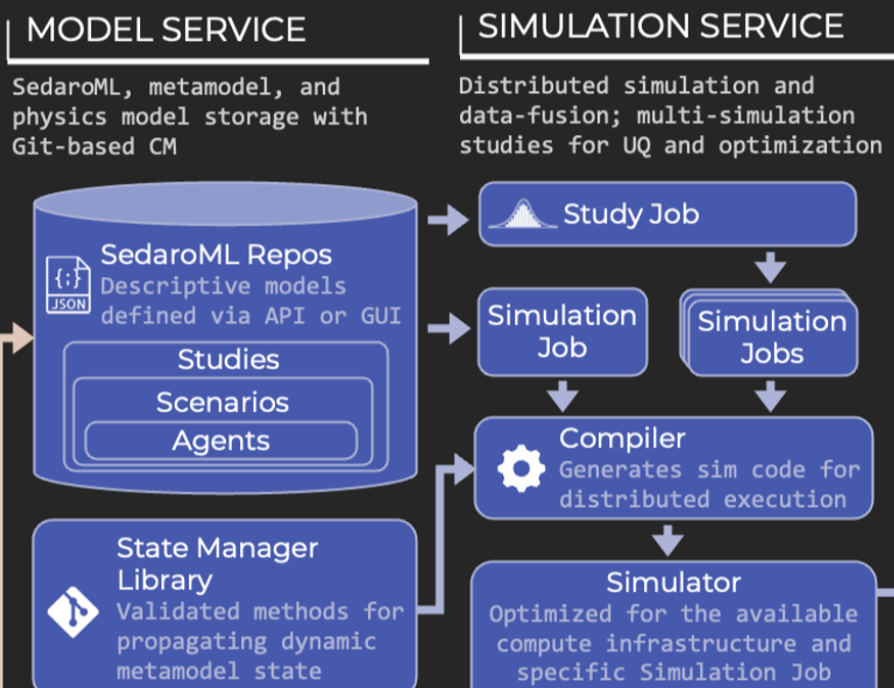




Results of the Studies SimulationJobs can be easily loaded into jupyter notebooks with helper functions for model parameter plotting and statistical analysed 

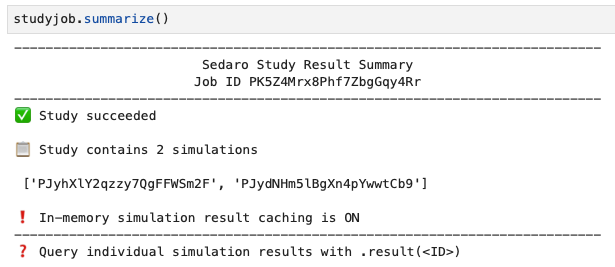

Statistics for individual Models  

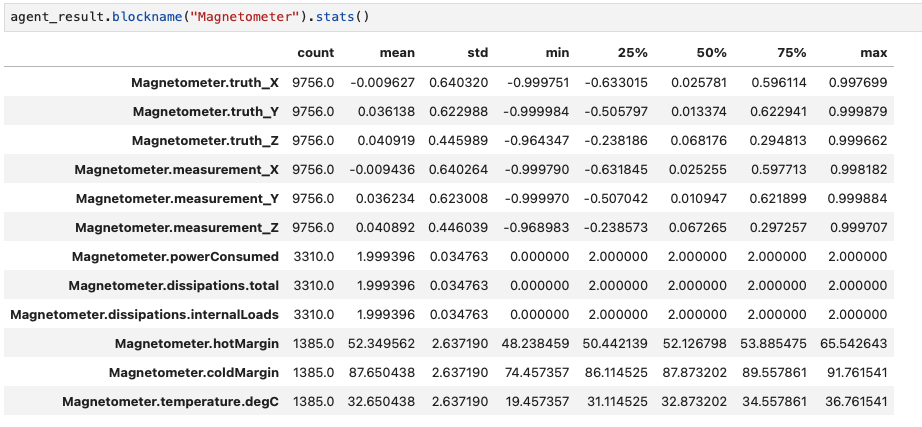

Model parameter histograms are available

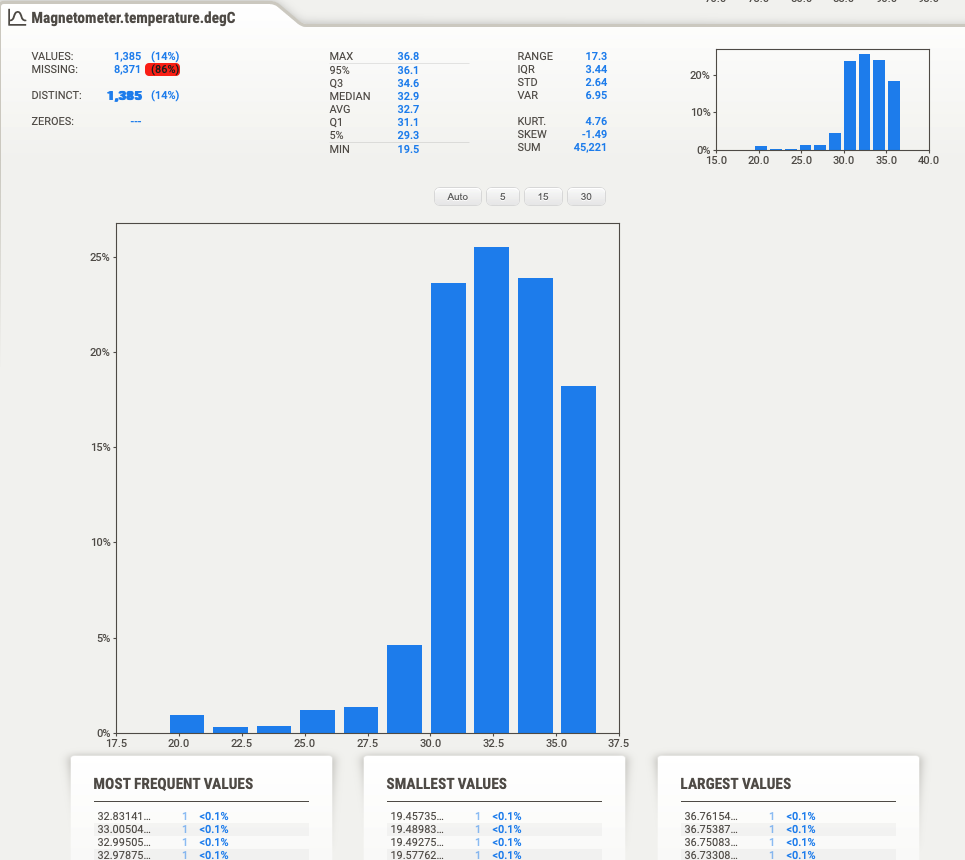

Along with Model scatter plots

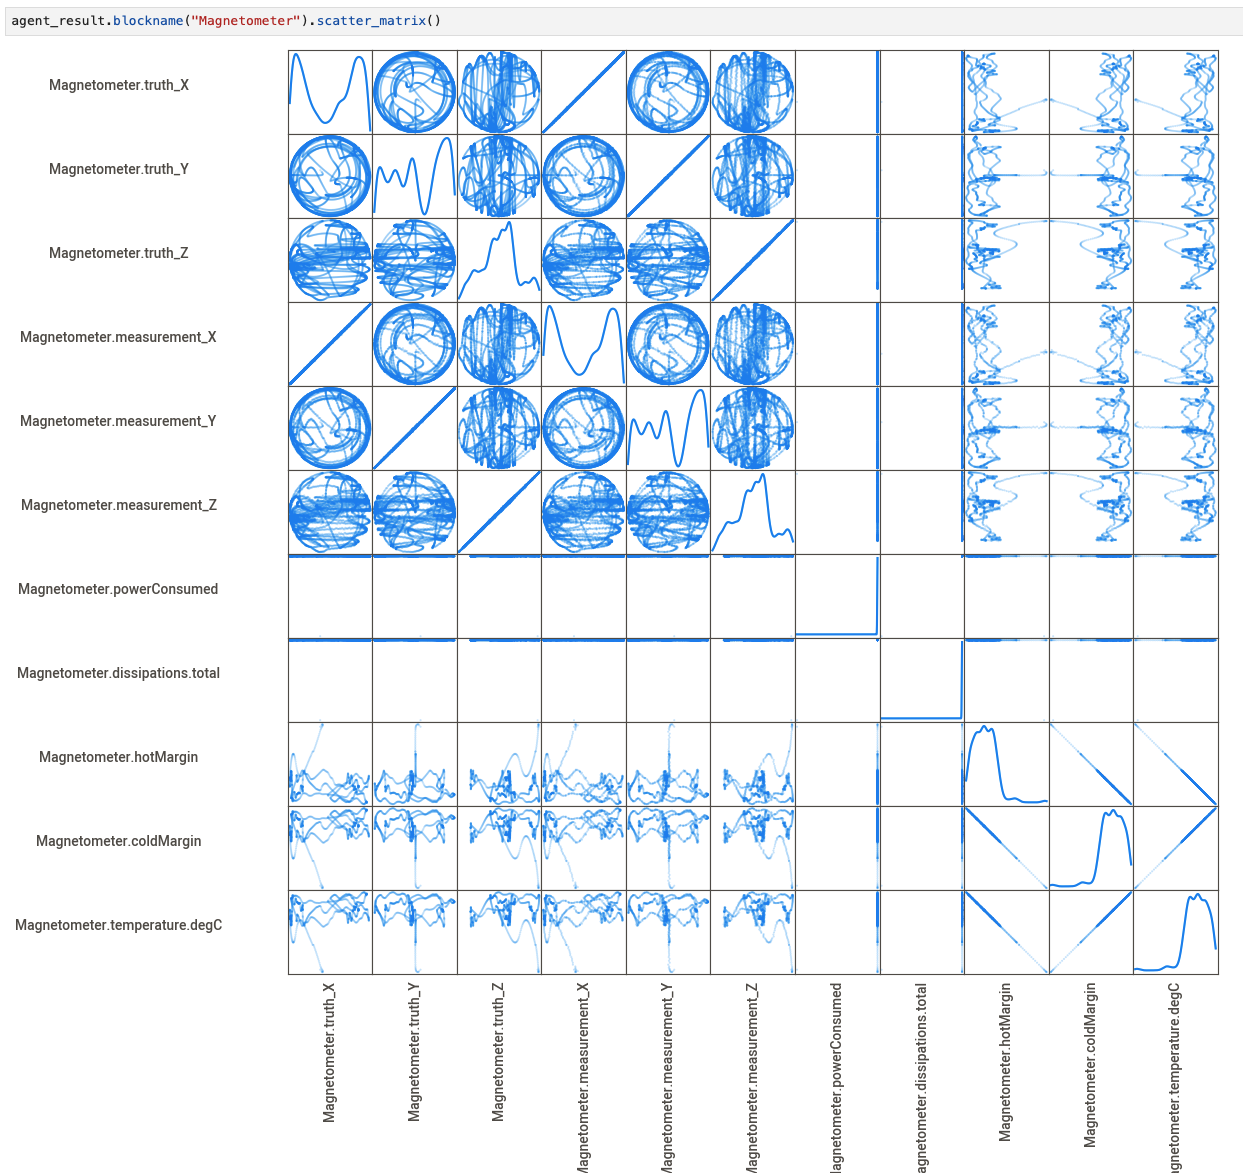


All existing Study objects of a scenario_branch can be listed via runnng the following cell:  

In [ ]:
resource = f'/simulations/branches/{scenario_branch_id}/control/study/'
sedaroAPI.request.get(resource)

but if this is the first time running this notebook then a empty list **[]** will  be returned.

## Study
Created via the sedaro-python REST post method   
```
resource = f'/simulations/branches/{scenario_branch_id}/control/study/'
result = sedaroAPI.request.post(resource,
       body={
            "iterations": 3,    # must be greater than one up to MAX_STUDY_ITERATIONS (currently 250)
            "overrideId": "ID", # <optional>
            "capacity": int,    # <optional>
            })
```
where the body can have the following options:
- **iterations**: positive int
 - number of times to run the selected branch scenario. Each time a different random seed will be used. 
 - sets a special variable "sim_index" for each simulation run starting at zero and is incremented by one
    - aka an index from  0 to (iterations - 1) for each simulation run.
- **capacity**: positive int. 
 - Used to limit the number of concurrent study simulation runs. 
- **overrideId**: string.  
 - Loads a set of defined override commands that will be applied before each simulation of the study is run. Starting model parameters changed by override commands are saved as a snapshot.


# Overview of the overrides feature
Override objects provide a means of varying Agent model parameters in a scenario to explore trade spaces and result sensitivities in your Agent design.  They can be defined as JSON or Python objects.

Summary of what do override objects do?
- Change starting values of model parameters via selected function(s)
  - Saves these model parameter changes so they can be loaded and re-run later (called snapshots) 
- Available functions include 
  - random draws from various distributions types
  - basic math operators
  - table lookups
  - variable support
  - value clamping
*Note: The **Function** random choices are deterministic between simulation runs.*



Override objects consist of a:
 - **path** to the Agent model parameter to change and a 
 - **function** to perform the actual change itself.

> Note: *Variables* can be used to hold a value of a model parameter or a constant. They are used to ease modification of override values and provide a means to ensure overall model consistency.

The **functions** used to change Agent model parameters support trade-space tables and randomized assignment via functions available in Pythons Random module.

In [37]:
# The following code will list all the override sets currently defined for the scenario branch
[ (overrideset.name, overrideset.id) for overrideset in wildfire_scenario_branch.OverrideSet.get_all()]

[('Tradespace Example', 'PKghWNfbXwHLq8xBDPKsZg')]

## Paths
An addressing means to access a model parameter of an Agent. Currently there are two versions:
- "**path**": A human readable format based on the names of models and its components. 
 - Format: Agent Name / blockname / parameter name / sub series
 - Example: “Wildfire/Crosslink/minTimeBetweenOccurrences/min”
 - Uses “/“ as a delimiter to mimic file location paths
- "**agent_key**": Based on the ids of a model and its components.
 - Format: agent_id.data.blocks.block_id.parameter.subseries
 - Example: “NT0LWIfSJ1RIenKpUmJEV.data.blocks.NV0bIfUUj9e6l-PX4ql1V.loadDefParams.power”
 - Uses ‘.’ for the separator
 - Similar to how Sedaro results streams are named

## Variables
Used to ensure consistency when assigning random values to parameters. When a model parameter is set with the result of a random fn, its value can be saved to a variable in order to update other model parameters that are affected by the change. 

> For example if the area of a solar panel is randomly assigned via a selected distribution function, then the mass of the panel and the Agents overall mass, will need to be adjusted accordingly.

They are initially defined in the variable section of a JSON or Python Override Object. 

### Built-in Variables
Always available to use as values for function arguments

| Name | Description |
| :-: | :- |
| x |  Replaced by the value in the parameter path before the function is run |
| original | Same as 'x' but more explicit |

### User defined
Defined in the "variables" section of the overrides datastructure

The following python command will list all currently defined variables for the first OverrideSet as pydantic json objects

In [38]:
wildfire_scenario_branch.OverrideSet.get('PKghWNfbXwHLq8xBDPKsZg').variables

[{'agent_key': None,
  'equals': None,
  'name': 'Baseline_mass',
  'path': 'Wildfire/data/mass'},
 {'agent_key': None,
  'equals': 2.2,
  'name': 'SAR-10237_mass_delta',
  'path': None},
 {'agent_key': None,
  'equals': 3.2,
  'name': 'SAR-10239_mass_delta',
  'path': None},
 {'agent_key': None,
  'equals': -0.702,
  'name': 'P33081_mass_delta',
  'path': None},
 {'agent_key': None,
  'equals': None,
  'name': 'Baseline_dry_inertia_X.X',
  'path': 'Wildfire/data/inertia/0/0'},
 {'agent_key': None,
  'equals': None,
  'name': 'Baseline_dry_inertia_Y.Y',
  'path': 'Wildfire/data/inertia/1/1'},
 {'agent_key': None,
  'equals': None,
  'name': 'Baseline_dry_inertia_Z.Z',
  'path': 'Wildfire/data/inertia/2/2'}]



or defined as a list of json objects

In [32]:
variables = [
    {
        "name": "gyroHotTemp",
        "path": "Wildfire/Gyro/hotTempRating/degC",      
    },
    {
        "name": "gyro_Sandwich",
        "equals": "tasty"
    }
]

Variables objects must have a 'name' and either:
- A **path** or **Agent_path** key which assigned the variable to the parameters current value
- or A **equals** key which sets the variable to a given value.
 - This value must be the same type of the parameter, aka string, int, or float
  - A key: value pair is used for paths with sub series
   - Example: { "Degrees": 90 } 
 - Values in arrays or lists must have the index in the path address
   - Example: 
     - */Wildfire/data/inertia/0* is the first element of the model parameter inertia list aka **inertia[0]**

## Override Functions
A function executed with provided arguments and stores the result in the model parameter listed in the path key.

### Available override functions
From basic arithmetic to drawing random numbers from a distribution, Sedaro provides a number of built-in functions for use to set starting values of Agent model parameters. 

#### Fn Summary Table
| Basic Math Operators | | Python | Random Module |   |
| :-: | -|  - | - | - |
| + | | choices | sample | randrange | 
| - | | uniform |triangular |expovariate | 
| * | | gammavariate | gauss | normalvariate | 
| / | | lognormvariate | vonmisesvariate | 
| = | | paretovariate | weibullvariate |


#### Basic math operators +, -, *, /, =
Performs the math operator with the current value of the model parameter then stores the results on the given parameter

Examples:
```
{
    "path": "Wildfire/Gyro/hotTempRating/degC",
    "fn": "=",
    "arg": 90.0
},
```
- Sets the model parameter *Wildfire/Gyro/hotTempRating/degC* to 90.0, overriding its original value of 100.0

```
{
   "path": "Wildfire/Power Processor/thermalCapacitance",
   "fn": "*",
   "arg": 1.2
}
```
- Will multiply the original value of the *Wildfire/Power Processor/thermalCapacitance* model parameter by 1.2
- Then it will set the result to the *Wildfire/Power Processor/thermalCapacitance* model parameter

#### Python random module functions
Allows the use of the functions available in pythons random module. These include various random number draws from various types of distribution curves, choices from a list with weights, and so on. More information about these functions can be found here: [https://docs.python.org/3/library/random.html]

---
- Functions for integers
  - Randrange(start, stop[, step]) 
    - generates a random integer within the specified range

---
- Functions for sequences
  -  Choices(population, weights=None, *, cum_weights=None, k=1) 
    - Return a k sized list of elements chosen from the population with replacement. 
  -  Sample(population, k, *, counts=None) 
    - Return a k length list of unique elements chosen from the population sequence. Used for random sampling without replacement.

---
- Real-valued distributions
  - Uniform(a, b) 
    - generates a random float between a and b
  - Triangular(low, high, mode) 
    - Return a random floating point number N such that low <= N <= high
  - Expovariate(lambd=1.0) 
    - Exponential distribution. lambd is 1.0 divided by the desired mean. It should be nonzero.
  - gammavariate(alpha, beta) 
    - Gamma distribution. (Not the gamma function!) The shape and scale parameters, alpha and beta, must have positive values.
  - gauss(mu=0.0, sigma=1.0) 
    - Normal distribution, also called the Gaussian distribution. mu is the mean, and sigma is the standard deviation. 
  - normalvariate(mu=0.0, sigma=1.0) 
    - Normal distribution. mu is the mean, and sigma is the standard deviation.
  - lognormvariate(mu, sigma) 
    - Log normal distribution. If you take the natural logarithm of this distribution, you’ll get a normal distribution with mean mu and standard deviation sigma. 
  - vonmisesvariate(mu, kappa) 
    - mu is the mean angle, expressed in radians between 0 and 2*pi, and kappa is the concentration parameter, which must be greater than or equal to zero.
  - paretovariate(alpha) 
    - Pareto distribution. alpha is the shape parameter.
  - weibullvariate(alpha, beta) 
    - Weibull distribution. alpha is the scale parameter and beta is the shape parameter.
---

Examples:
```
{
    "path": "Wildfire/Battery/initialSoc", # starts as 0.8.
    "fn": "choices",
    "population": [0.6, 0.9], 
    "weights":[1.0, 0.5], 
    "k":1
},
```
Will run the python *random.choices* function with **[0.6, 0.9]** as its *population* and **[1.0,0.5]** as its *weights* arguements
and sets the Agent Model parameter **Wildfire/Battery/initialSoc** to the result.


```
{
    "path": "Wildfire/-Z Surface/temperature/degC", # 20.0
    "fn": "normalvariate",
    "mu": "x", 
    "sigma": 2.0 
},
```
Runs the python *random.normalvariate* function with the arguement *sigma* set to **2.0** and the *mu* arguement set to the current Agents Model parameter **'Wildfire/-Z Surface/temperature/degC'** value. 
> In this example: If the current parameter "Wildfire/-Z Surface/temperature/degC" value was **20.0**, then the *'x'* is replaced by **20.0** which is then used as the *mu* argument for the function call.


##### Function Signatures
Varies, based on the signature of the python random module itself. See the Signatures addendix for details. 

Example:
The python random module function "WeibullVariate" has the following signature:
```
class WeibullVariate(PathFn):
    fn: Literal["weibullvariate"]
    alpha: int | float 
    beta:  int | float 
```
This states the WeibullVariate function expects its alpha and beta parameters to be an integer, float, or string
> Do note arguments can be set with *str* types in this context of defined variable names which are replaced by the variable value before running the function. 


### fn_chain
Performs the provided list of fn overrides in order, each time storing the result in the given parameter path  

Signature:
```
class FnChain(PAthFn):
    fn_chain: List[ possible_fns ]
```

Example:
Given the following **fn_chain** override json
```
{
   "path": "Wildfire/Power Processor/thermalCapacitance",
   "fn_chain": [
          {"fn": "*", "arg": 1.2}, 
          {"fn": "-", "arg": 1.0}, 
          {"fn": "triangular", "low": 4000, "high": 4500, "mode": "x" },
          {"fn": "clamp", "low": 4100} ]
}
```
- Will first multiply the value located in the *thermalCapacitance* parameter of the *Wildfire/Power Processor* model by **1.2**
- Then it will substract **1.0** from the previous result
- Then draw a random value from a *triangular* shaped distribution centered around the **current result** *(x is replaced by the current result)*, with low of **4000** and the high of **4500**
- Then clamp the final result to be **4100** or greater
- the final result is then stored in the *Wildfire/Power Processor/thermalCapacitance* parameter

### sim_index
Used to perform tradespace studies. The StudyJob object will create SimJobs each with an unique index. The **sim_index** override will use this index to select from a list of **fn** overrides to use for that SimJob.

The **sim_index**  is modulated by the size of the provided override fn list
> fn used = fn_list[ int(sim_index)%len(fn_list) ]

Signature
``` python
class SimIndex(PathFn):
    sim_index: List[ possible_fns ]
```
Example:
Given the following **sim_index** entry JSON 

``` json
{
  "path": "Wildfire/Power Processor/thermalCapacitance",
  "seed_index": [ 
                {"fn": "uniform",
                  "a": 2900.0, 
                  "b": 3100  },
                {"fn": "=", "arg": 3000.0}, 
                {"fn": "*", "arg": 1.2}, 
  ]
}
```
Assuming a study with 3 iterations, 
- the first Simulation Job will pull a random value from the uniform distrubation from 2900.0 to 3100.0 
  - and set the **Power Processor/thermalCapacitance** model parameter to its result.
- The second Simulation will directly set the **Power Processor/thermalCapacitance** model parameter to 3000.0.
- The third Simulation will multiply the current  **Power Processor/thermalCapacitance** model parameter by 1.2 and set the parameter value to the result.


### copy_value_to (*Working name*)
Copies the current value of a model parameter into a variable. 

Example:
``` json
{
    "path": "Wildfire/Gyro/hotTempRating/degC",
    "copy_value_to": "gyroHotTemp"          
},
```

Will place the value of the **Wildfire/Gyro/hotTempRating/degC** model parameter into the **gyroHotTemp** variable.

In [ ]:
# or 
copy_value_override = CopyValueTo.create(path="Wildfire/Gyro/hotTempRating/degC", 
                                         copy_value_to="gyroHotTemp")

### clamp
Bounds a parameter value to a given range. Meant to be used with a fn_chain to ensure a randomly set value is within valid bounds.

Example:
``` json
{
    "path":"Wildfire/Power Processor/thermalCapacitance",
    "fn": "clamp", "low": 4100 
},
```
Will set the model parameter **Wildfire/Power Processor/thermalCapacitance** to 4100 if its current value is below the *low* value of 4100

### clampRepeat (**New**)
Will rerun a given function up to 5 times if the result is outside a given range. Meant to be used with random based override functions.

Example:
``` json
{ 
   
   "path": "LaserComm-1/Quiescent/loadDefParams/power",
   "fn": "clampRepeat",
   "low": 4,
   "high": 5,
   "overrideFn": {
      "fn": "weibullvariate",
      "alpha": 4.5,
      "beta": 1.2,
   }
}
```
Will run the random **weibullvariate** distribution function up to 5 times until a result between 4 and 5 is returned, then it sets the model parameter *LaserComm-1/Quiescent/loadDefParams/power* to it. 

Note: the model parameter will remain its original value if the result clamp [low high] range requirement is not met.

# Example Studies
This notebook has two example studies to demostrate the studies feature set.

The first is a example of how to setup and run a simple tradespace of the effects of battery cell swapouts to overall vehicle/agent manueverability. It works thru the process of building a tradespace table and translating the table to an OverrideSet object consisting of override commands, running the tradespace, and how to analyse the results. This example is purposely not using random parameter assignments to keep it simple.

The second 




## Wildfire Tradespace Analysis: Battery Size vs. Mass effects on Agent maneuverability
The first study example will show the effects of Agent maneuverability, measured by the Wildfire Agent total in Field of view time to its ground stations, by the choice of battery size and weight. 



### Setup
Find or make a branch of the wildfire scenaro and record its branch ID value.



### Optional: Load shared workspace to skip setup and running the study
TODO - couldn't get python client to load data from shared workspace


#### Research
- Data sources: 
  - Spec sheets for satellite batteries (https://www.eaglepicher.com/markets/space/satellites/)

In particular:
- Primary Lithium-Ion Cells Space COTS Batteries Offerings from Eaglepicher
  - (https://www.eaglepicher.com/sites/default/files/COTS%201022.pdf):
  - 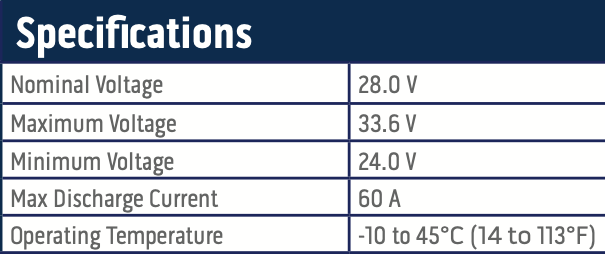
  
|  | Specifications |
| :-: | :-: |
| Nominal Voltage | 28.0 V |
| Maximum Voltage | 33.6 V |
| Minimum Voltage | 24.0 V |
| Max Discharge Current | 60 A |
| Operating Temperature | -10 to 45°C (14 to 113°F) |

  - 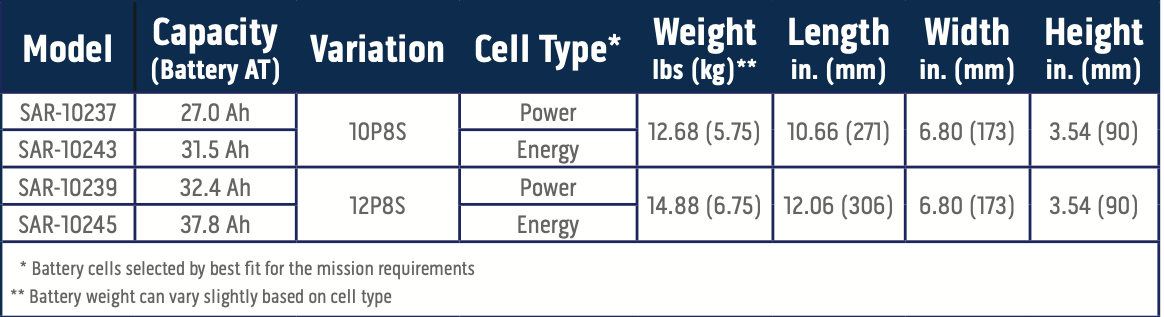
  
| Model | Capacity | Variation | Cell Type | Weight lbs(kgs) | Length in.(mm) | Width in. (mm) | Height in. (mm) | volume in^3 | 
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| SAR-10237 | 27.0 Ah | 10P8S | Power | 12.68 (5.75) | 10.66 (271)  | 6.8 (173) | 3.54 (90) | 256.607 |
| SAR-10243 | 31.5 Ah | | Energy |  | |
| |
| SAR-10239 | 32.4 Ah | 12P8S | Power | 14.88 (6.75) | 12.06 (306) | 6.8 (173) | 3.54 (90) | 303.3 |
| SAR-10243 | 31.5 Ah |  | Energy |  | |
| P33081    | 30 Ah   |  |  | 2.1 (0.950) |  5.985 (150) | 3.771(96) | 1.108 (28.1) | 25.00 |
| LP33330   |  6Ah    |  |  | 0.222    | 1.964     |   0.874   |  3.064 | 5.259 |


The LP33330 cell is the baseline cell in a 2 Parallel and 8 series arrangement (aka 16 cells total).
```
= ~ 24 to 32 volts
= 12Ah
= 0.222 * 16 --> 3.552 kg
= 5.259 * 16 --> 84.15 cubic in -->  1378.97144 Cubic cm of space used on the agent
```

```
SAR-10237 can fit 0.3279 cells in the space --> 1 cell adds 2.20 kg
SAR-10239 can fit 0.2774 cells in the space --> 1 cell adds 3.20 kg
P33081    can fit 3.366  cells in the space --> 3 cells removes 0.702 kg  
```



#### Create tradespace table 
Model SAR-10237: **Volume** = 271 * 173 * 90 --> 4.21947 cm^3  / **Mass** (5.750 kg) --> **Density** = 1362.7303903097  kg/m3
Mass times number of cells  = 5.750 kg * 10 = 


Model SAR-10239: **Volume** = 306 * 173 * 90 --> 4.7642 cm^3 / **Mass** (6.750 kg)  --> **Density** = 1416.751671767  kg/m3
Mass times number of cells  = 6.750 kg * 10 = 


Model P33081: **Volume** = in 150 * 96 * 28.1 --> .40464 cm^3  / **Mass** (950 g)   --> **Density** = 2347.7659153816 kg/m3
Mass times number of cells  = 6.750 kg * 10 = 


| Agent Parameter | Sim LP33330 Baseline | Sim SAR-10237 Value | Sim SAR-10239 Value | Sim P33081 Value | Parameter Path | Agent_ID_PATH |
| :-: | :-: | :-: | :-: | :-: | :-: |:-: |
| Battery pack mass(kg) | 3.552 | 5.750 | 6.750 | 2.850 | /Wildfire/data/mass | 'NT06aqHUT5djI1_JPAsck.data.mass' |
| Dry Inertia(kg m^2) X.X | 270.0 | (A) | (A) | (A) | /Wildfire/data/inertia/0/0 | 'NT06aqHUT5djI1_JPAsck.data.inertia.0.0' |
| Dry Inertia(kg m^2) Y.Y | 420.0 | (B) | (B) | (B) | /Wildfire/data/inertia/1/1 | 'NT06aqHUT5djI1_JPAsck.data.inertia.1.1' |
| Dry Inertia(kg m^2) Z.Z | 520.0 | (C) | (C) | (C) | /Wildfire/data/inertia/2/2 | 'NT06aqHUT5djI1_JPAsck.data.inertia.2.2' |

(A) Dry Inerta X.X = original/mass * delta + original

(B) Dry Inerta Y.Y = original/mass * delta + original

(C) Dry Inerta Z.Z = original/mass * delta + original


#### Deternmine Parameter Paths
Search for the model parameter paths to override using the path search function

In [ ]:
# TODO add simple path/agent_key search function

The paths we will be modifying will be:
- **'NT06aqHUT5djI1_JPAsck.data.mass'**: 1000.0,
    - */Wildfire/data/mass*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.0.0'**: 270.0,
    - *Wildfire/data/inertia/0/0*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.0.1'**: 0.0,
    - *Wildfire/data/inertia/0/1*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.0.2'**: 0.0,
    - *Wildfire/data/inertia/0/2*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.1.0'**: 0.0,
    - *Wildfire/data/inertia/1/0*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.1.1'**: 420.0,
    - *Wildfire/data/inertia/1/1*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.1.2'**: 0.0,
    - *Wildfire/data/inertia/1/2*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.2.0'**: 0.0,
    - *Wildfire/data/inertia/2/0*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.2.1'**: 0.0,
    - *Wildfire/data/inertia/2/1*
- **'NT06aqHUT5djI1_JPAsck.data.inertia.2.2'**: 520.0,
    - *Wildfire/data/inertia/2/2*


#### Overrides used
We will use the sim_index override to run the above tradespace table:

In [8]:
tradespace_overrides_dict = {
  "name": "Tradespace Example",
  "variables": [
    {
      "name": "Baseline_mass",
      "path": "Wildfire/data/mass"
    },
    {
      "name": "SAR-10237_mass_delta",
      "equals": 2.20
    },
    {
      "name": "SAR-10239_mass_delta",
      "equals": 3.20
    },
    {
      "name": "P33081_mass_delta",
      "equals": -0.702
    },
    {
      "name": "Baseline_dry_inertia_X.X",
      "path": "Wildfire/data/inertia/0/0"
    },
    {
      "name": "Baseline_dry_inertia_Y.Y",
      "path": "Wildfire/data/inertia/1/1"
    },
    {
      "name": "Baseline_dry_inertia_Z.Z",
      "path": "Wildfire/data/inertia/2/2"
    }
  ],
  "overrides": [
    {
      "path": "Wildfire/data/mass",
      "sim_index": [ 
                      {"fn": "=", "arg": "Baseline_mass"}, 
                      {"fn": "+", "arg": "SAR-10237_mass_delta"}, 
                      {"fn": "+", "arg": "SAR-10239_mass_delta"}, 
                      {"fn": "+", "arg": "P33081_mass_delta"}, 
                  ]
    },
    {
      "agent_key": "NT06aqHUT5djI1_JPAsck.data.inertia.0.0",
      "sim_index": [ 
                      {"fn": "=", "arg": "Baseline_dry_inertia_X.X"}, 
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "SAR-10237_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_X.X" } ] 
                      },
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "SAR-10239_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_X.X" } ] 
                      },
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "P33081_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_X.X" } ] 
                      },
                  ]
    },
    {
      "agent_key": "NT06aqHUT5djI1_JPAsck.data.inertia.1.1",
      "sim_index": [ 
                      {"fn": "=", "arg": "Baseline_dry_inertia_Y.Y"}, 
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "SAR-10237_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_Y.Y" } ] 
                      },
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "SAR-10239_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_Y.Y" } ] 
                      },
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "P33081_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_Y.Y" } ] 
                      },
                  ]
    },
    {
      "agent_key": "NT06aqHUT5djI1_JPAsck.data.inertia.2.2",
      "sim_index": [ 
                      {"fn": "=", "arg": "Baseline_dry_inertia_Z.Z"}, 
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "SAR-10237_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_Z.Z" } ] 
                      },
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "SAR-10239_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_Z.Z" } ] 
                      },
                      { "fn_chain": [
                          {"fn": "/", "arg": "Baseline_mass"}, 
                          {"fn": "*", "arg": "P33081_mass_delta"}, 
                          {"fn": "+", "arg": "Baseline_dry_inertia_Z.Z" } ] 
                      },
                  ]
    },
  ]
}

In [166]:
tradespace_overrides_block = wildfire_scenario_branch.OverrideSet.create(**tradespace_overrides_dict)


In [10]:
tradespace_overrides_block


OverrideSet(
   disabled=False
   id='PKghWNfbXwHLq8xBDPKsZg'
   name='Tradespace Example'
   overrides=[{'agent_key': None, 'path': 'Wildfire/data/mass', 'sim_index': [{'agent_key': None, 'arg': 'Baseline_mass', 'fn': '=', 'path': None}, {'agent_key': None, 'arg': 'SAR-10237_mass_delta', 'fn': '+', 'path': None}, {'agent_key': None, 'arg': 'SAR-10239_mass_delta', 'fn': '+', 'path': None}, {'agent_key': None, 'arg': 'P33081_mass_delta', 'fn': '+', 'path': None}]}, {'agent_key': 'NT06aqHUT5djI1_JPAsck.data.inertia.0.0', 'path': None, 'sim_index': [{'agent_key': None, 'arg': 'Baseline_dry_inertia_X.X', 'fn': '=', 'path': None}, {'agent_key': None, 'fn_chain': [{'agent_key': None, 'arg': 'Baseline_mass', 'fn': '/', 'path': None}, {'agent_key': None, 'arg': 'SAR-10237_mass_delta', 'fn': '*', 'path': None}, {'agent_key': None, 'arg': 'Baseline_dry_inertia_X.X', 'fn': '+', 'path': None}], 'path': None}, {'agent_key': None, 'fn_chain': [{'agent_key': None, 'arg': 'Baseline_mass', 'fn': '/', 

record the generated override block ID

In [9]:
tradespace_overrides_block = (wildfire_scenario_branch.OverrideSet.get_first())

In [12]:
tradespace_overrides_id = tradespace_overrides_block.id

#### Create and Run Study 

In [180]:
create_study_resource_url = f'/simulations/branches/{scenario_branch_id}/control/study/'
new_studyjob = sedaroAPI.request.post(  create_study_resource_url,
                                        body={
                                                "iterations": 4,
                                                "override_id": tradespace_overrides_id
                                                })

In [181]:
new_studyjob

{'branch': 'PKgBt4JWCmLVFBBzQBK3d8',
 'dateCreated': '2023-11-30T19:38:13.603Z',
 'dateModified': '2023-11-30T19:38:13.603Z',
 'id': 'PKgkfnZgK4RhXcBdk9h89J',
 'jobType': 'STUDY',
 'jobs': [],
 'message': 'Started study successfully.',
 'predecessor': None,
 'scenarioHash': 'c5f44bbf7ed3d88f81d398a367b364afe863a32fc49aad37d30f279ae51a24bd',
 'status': 'PENDING',
 'successors': [],
 'workspace': 'PKgBsyk48JVMJcL59yvcWM'}

In [12]:
#first_study = wildfire_scenario_branch.Study.get_first()
study_id = 'PKgkfnZgK4RhXcBdk9h89J' # new_studyjob['id'] #
study_control_resource = f'/simulations/branches/{scenario_branch_id}/control/study/{study_id}'

### Check on Study Status

In [13]:
study_status = sedaroAPI.request.get(study_control_resource)

In [14]:
study_status

{'branch': 'PKgBt4JWCmLVFBBzQBK3d8',
 'dateCreated': '2023-11-30T19:38:13.603Z',
 'dateModified': '2023-11-30T21:57:02.594Z',
 'id': 'PKgkfnZgK4RhXcBdk9h89J',
 'jobType': 'STUDY',
 'jobs': ['PKgkfrljrWcPqxHbWCBfQq',
  'PKgkfvLfzcs9tGfkfRN7mb',
  'PKgkfvW4y9wQxDVjHzVsgZ',
  'PKgkfrXdHLYRslCZkvSy9m'],
 'message': 'Started study successfully.',
 'predecessor': None,
 'scenarioHash': 'c5f44bbf7ed3d88f81d398a367b364afe863a32fc49aad37d30f279ae51a24bd',
 'status': 'SUCCEEDED',
 'successors': [],
 'workspace': 'PKgBsyk48JVMJcL59yvcWM'}

In [15]:
study_job_ids = study_status['jobs']

To see all the status of the simuation jobs in the study run the following cell.
Note: SimulationJobs in the queued state will run once simulation resources are available to do so.

In [16]:
[ (f"SimJob ID: {job['id']}", f"Status: {job['status']}", f"Progress:", job['progress']) for job_id in study_job_ids for job in [sedaroAPI.request.get(f'/simulations/branches/{scenario_branch_id}/control/{job_id}')] ]

[('SimJob ID: PKgkfrljrWcPqxHbWCBfQq',
  'Status: TERMINATED',
  'Progress:',
  {'currentTime': None, 'percentComplete': None}),
 ('SimJob ID: PKgkfvLfzcs9tGfkfRN7mb',
  'Status: TERMINATED',
  'Progress:',
  {'currentTime': None, 'percentComplete': None}),
 ('SimJob ID: PKgkfvW4y9wQxDVjHzVsgZ',
  'Status: TERMINATED',
  'Progress:',
  {'currentTime': None, 'percentComplete': None}),
 ('SimJob ID: PKgkfrXdHLYRslCZkvSy9m',
  'Status: SUCCEEDED',
  'Progress:',
  {'currentTime': None, 'percentComplete': 100})]

Or you can view the scenario branch on the Web client to see the Study Simulation Jobs status by clicking the **'View Jobs'** button 

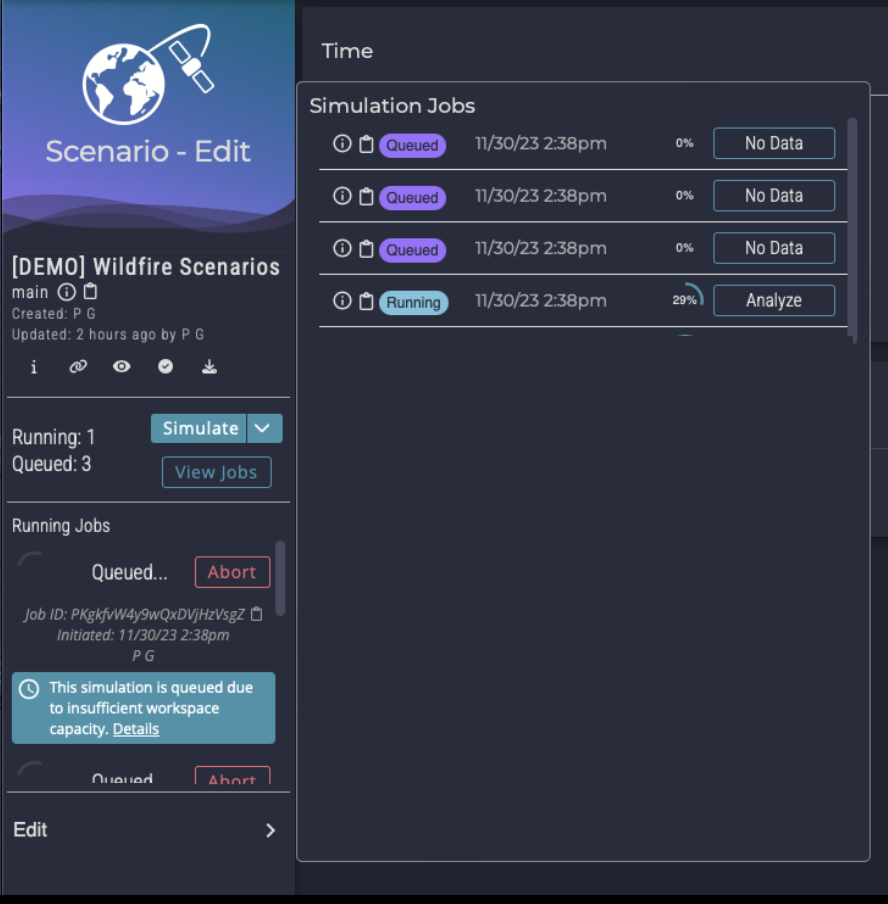


Once any the simulation jobs have finished, you can examine the results while waiting for the other to complete. 

### Load the results of the Study SimJobs

In [17]:
study_job = wildfire_scenario_branch.study.results(study_status['id'])

In [18]:
study_job.summarize()

---------------------------------------------------------------------------
                        Sedaro Study Result Summary                        
                       Job ID PKgkfnZgK4RhXcBdk9h89J                       
---------------------------------------------------------------------------
✅ Study succeeded

📋 Study contains 4 simulations

 ['PKgkfrljrWcPqxHbWCBfQq', 'PKgkfvLfzcs9tGfkfRN7mb', 'PKgkfvW4y9wQxDVjHzVsgZ', 'PKgkfrXdHLYRslCZkvSy9m']

❗ In-memory simulation result caching is ON
---------------------------------------------------------------------------
❓ Query individual simulation results with .result(<ID>)


In [19]:
study_tradespace_job_PKgkfrXdHLYRslCZkvSy9m_results = study_job.result('PKgkfrXdHLYRslCZkvSy9m')

💾 Downloading simulation result id PKgkfrXdHLYRslCZkvSy9m...done!


### Analyze Study results

In [20]:
study_tradespace_job_PKgkfrXdHLYRslCZkvSy9m_results.summarize()

---------------------------------------------------------------------------
                      Sedaro Simulation Result Summary                     
---------------------------------------------------------------------------
✅ Simulation succeeded after 1471.3s

🛰️ Templated Agents 
    • Wildfire
    • Ground Station: Cape Canaveral
    • Fire: Brook Mole
    • Fire: Chichen Itza
    • Fire: Jasper National Park
    • LaserComm-1
    • LaserComm-2
    • LaserComm-3
    • LaserComm-4
    • Ground Station: Hawaii

📡 Peripheral Agents 
    • Wildfire
    • Ground Station: Cape Canaveral
    • Fire: Brook Mole
    • Fire: Chichen Itza
    • Fire: Jasper National Park
    • LaserComm-1
    • LaserComm-2
    • LaserComm-3
    • LaserComm-4
    • Ground Station: Hawaii
---------------------------------------------------------------------------
❓ Query agent results with .agent(<NAME>)


In [21]:
study_alpha_Wildfire_agent_result = study_tradespace_job_PKgkfrXdHLYRslCZkvSy9m_results.agent('Wildfire')

In [24]:
study_alpha_Wildfire_agent_result.summarize()

---------------------------------------------------------------------------
                            Agent Result Summary                           
                                 'Wildfire'                                
---------------------------------------------------------------------------
🧩 Simulated Modules
    • Guidance, Navigation, & Control
    • Command & Data Handling
    • Power
    • Thermal

📦 Available Blocks
    ----------------------------------------------------------
    |                  id                         name       |
    ----------------------------------------------------------
    | root                       |                           |
    | YddJw9jfT-IveoP86XQjA      | <Unnamed Block>           |
    | PKJctGSk2hRGqbyTCvtgzm     | <Unnamed Block>           |
    | PKJctGSh45WgNcHZyyw9Pr     | <Unnamed Block>           |
    | PKJctGSf5v4NHqMy9fVj3J     | <Unnamed Block>           |
    | PKJctGSc45ZfznjQcqQtyc     | <Unnamed Block>        

**Remove before flight**
*A quick check of the Magnetometer block results to compare with the previous example.  Not related to study just a sanity check*  

count unique  top freq       mean   
Magnetometer.measurement_X               10064.0    NaN  NaN  NaN  -0.013177  \
Magnetometer.measurement_Y               10064.0    NaN  NaN  NaN  -0.083488   
Magnetometer.measurement_Z               10064.0    NaN  NaN  NaN  -0.140764   
Magnetometer.truth_X                     10064.0    NaN  NaN  NaN  -0.013154   
Magnetometer.truth_Y                     10064.0    NaN  NaN  NaN  -0.083538   
Magnetometer.truth_Z                     10064.0    NaN  NaN  NaN  -0.140754   
Magnetometer.activeDataMode                    0      0  NaN  NaN        NaN   
Magnetometer.powerConsumed                3396.0    NaN  NaN  NaN   1.999411   
Magnetometer.dissipations.total           3396.0    NaN  NaN  NaN   1.999411   
Magnetometer.dissipations.internalLoads   3396.0    NaN  NaN  NaN   1.999411   
Magnetometer.hotMargin                    1375.0    NaN  NaN  NaN  51.676161   
Magnetometer.coldMargin                   1375.0    NaN  NaN  NaN  88.323839   
Magnetometer.temperature.degC             1375.0    NaN  NaN  NaN  33.323839   

                                              std        min        25%   
Magnetometer.measurement_X               0.498055  -0.999964  -0.339068  \
Magnetometer.measurement_Y               0.540567   -0.99589  -0.556566   
Magnetometer.measurement_Z               0.657926  -0.999544  -0.701381   
Magnetometer.truth_X                     0.498001   -0.99999   -0.34042   
Magnetometer.truth_Y                      0.54051  -0.994717  -0.556322   
Magnetometer.truth_Z                      0.65801   -0.99915  -0.702011   
Magnetometer.activeDataMode                   NaN        NaN        NaN   
Magnetometer.powerConsumed                0.03432        0.0        2.0   
Magnetometer.dissipations.total           0.03432        0.0        2.0   
Magnetometer.dissipations.internalLoads   0.03432        0.0        2.0   
Magnetometer.hotMargin                   2.400677  48.810227  50.246797   
Magnetometer.coldMargin                  2.400677   74.47315   87.37963   
Magnetometer.temperature.degC            2.400677   19.47315   32.37963   

                                               50%        75%        max  
Magnetometer.measurement_X               -0.080943   0.381805   0.960739  
Magnetometer.measurement_Y               -0.090492   0.313791   0.997933  
Magnetometer.measurement_Z               -0.312594   0.484415   0.999993  
Magnetometer.truth_X                     -0.079996    0.38215   0.951653  
Magnetometer.truth_Y                     -0.091132   0.313119   0.995153  
Magnetometer.truth_Z                     -0.311541   0.482557   0.999995  
Magnetometer.activeDataMode                    NaN        NaN        NaN  
Magnetometer.powerConsumed                     2.0        2.0        2.0  
Magnetometer.dissipations.total                2.0        2.0        2.0  
Magnetometer.dissipations.internalLoads        2.0        2.0        2.0  
Magnetometer.hotMargin                   50.981794   52.62037   65.52685  
Magnetometer.coldMargin                  89.018206  89.753203  91.189773  
Magnetometer.temperature.degC            34.018206  34.753203  36.189773

Feature: Magnetometer.temperature.degC       |██████████| [100%]   00:09 -> (00:00 left)   



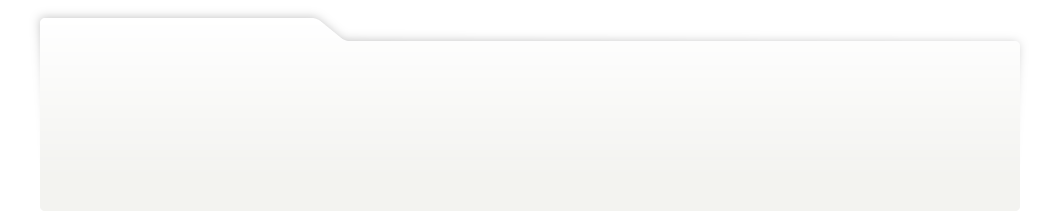
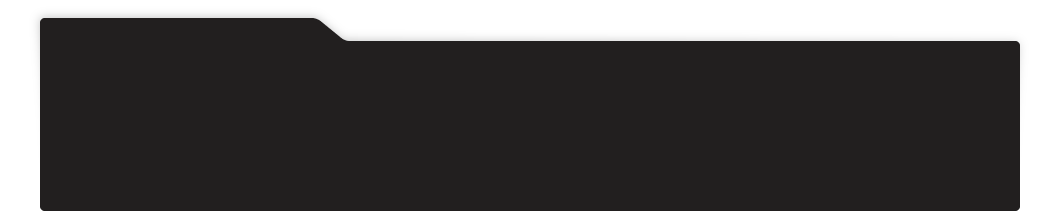
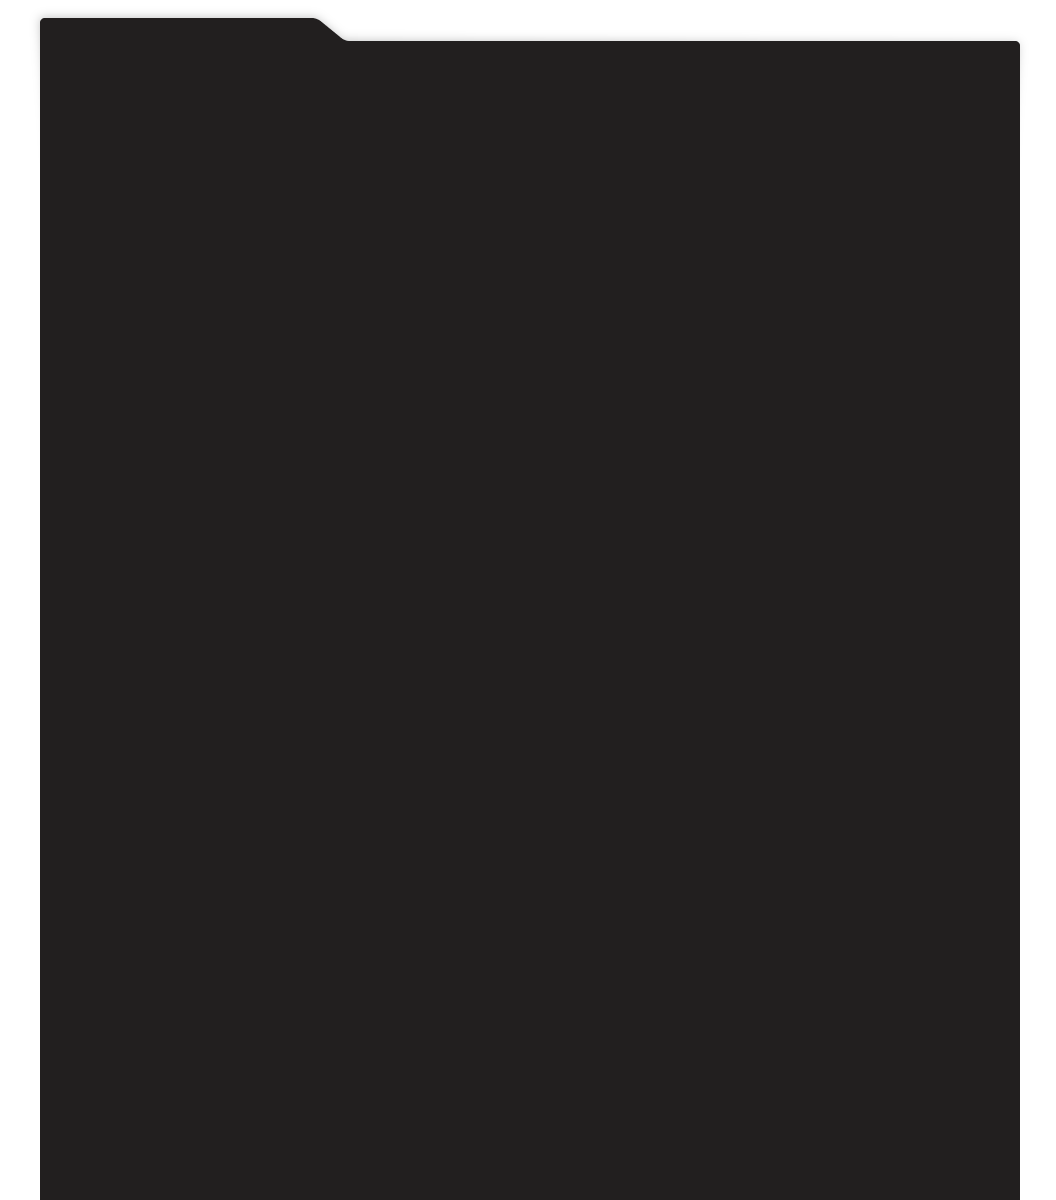
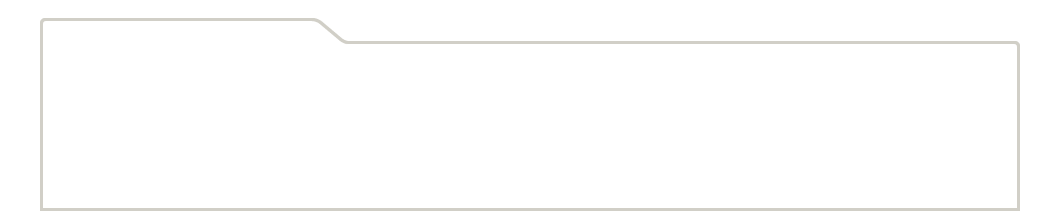
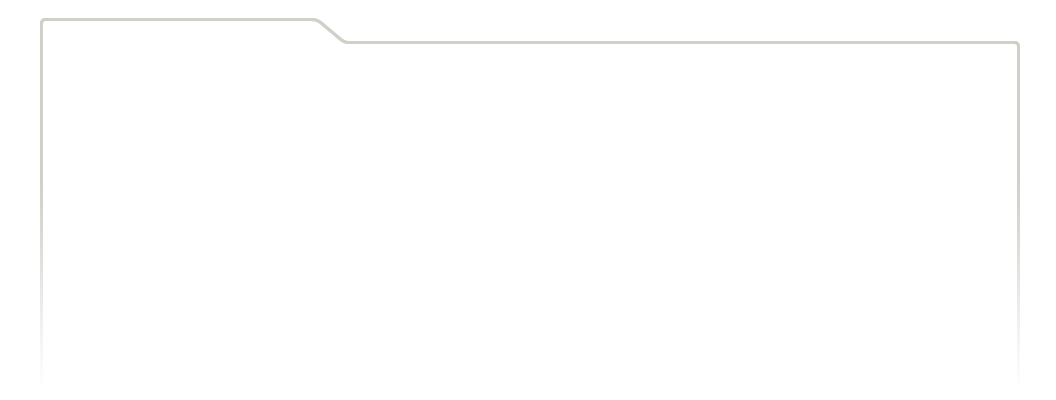
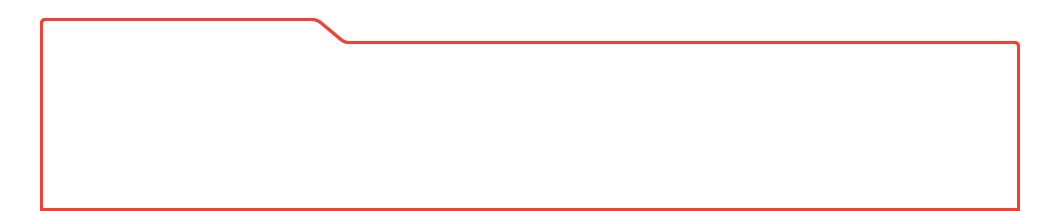
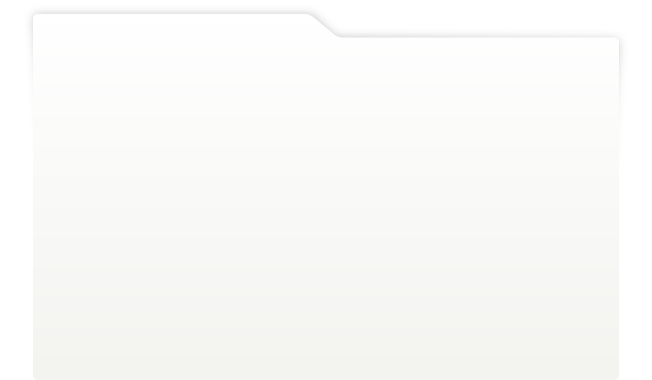
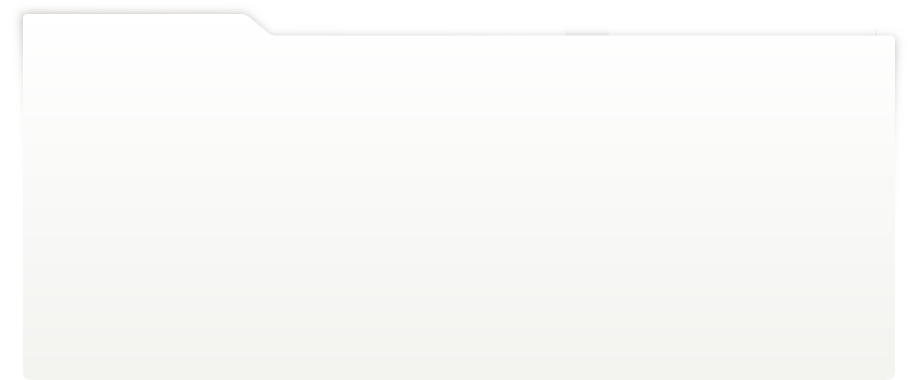
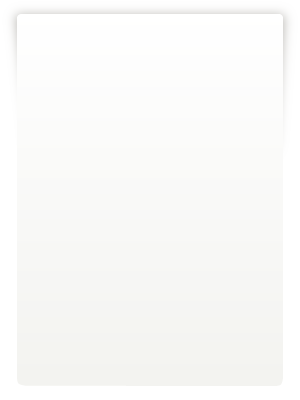
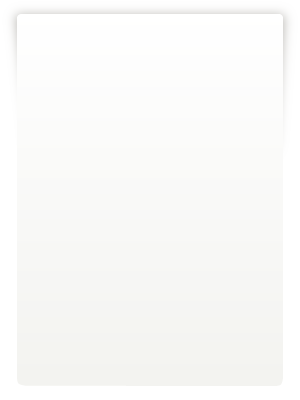
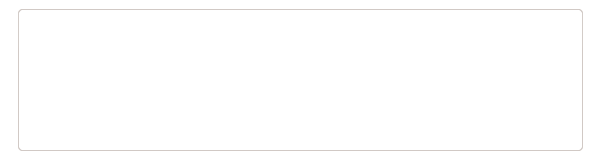
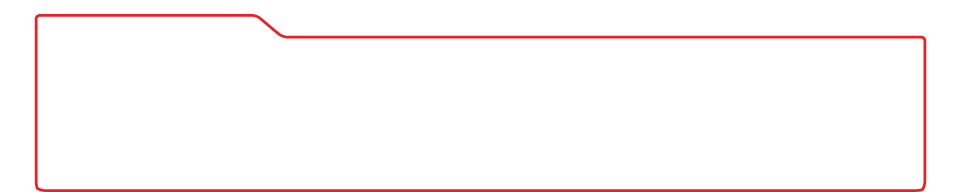
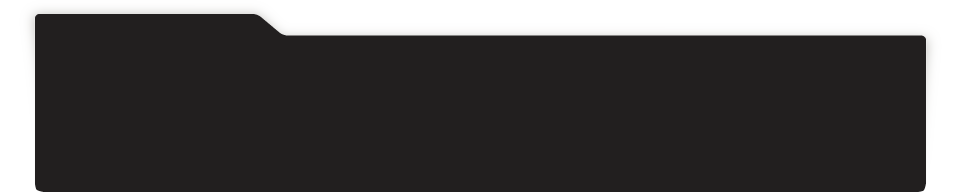
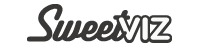
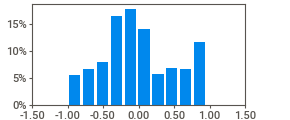
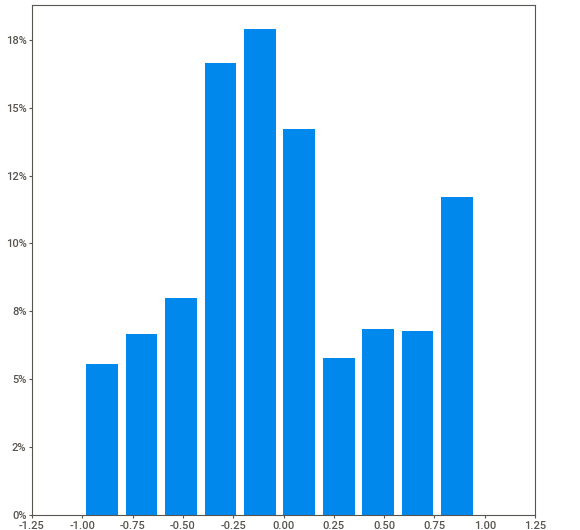
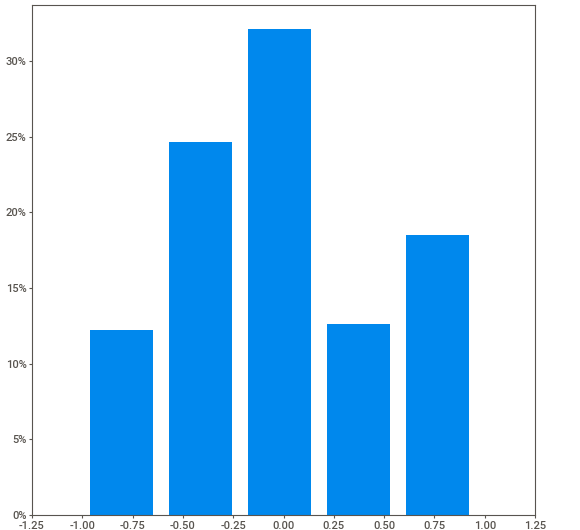
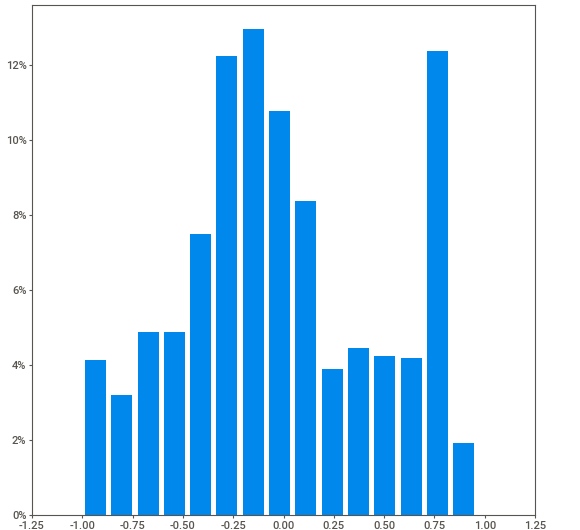
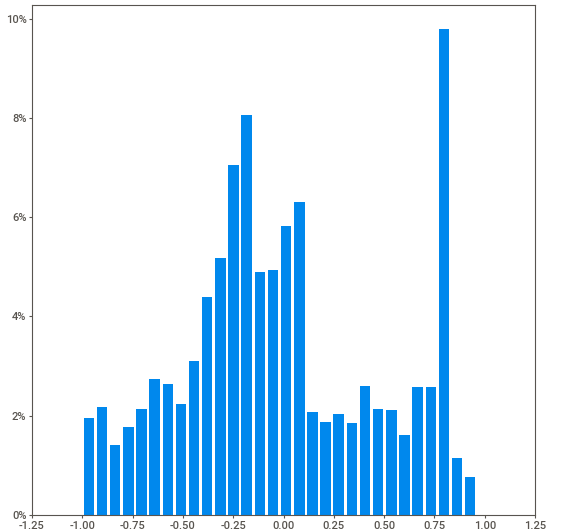
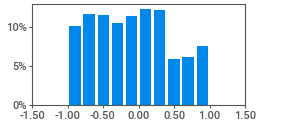
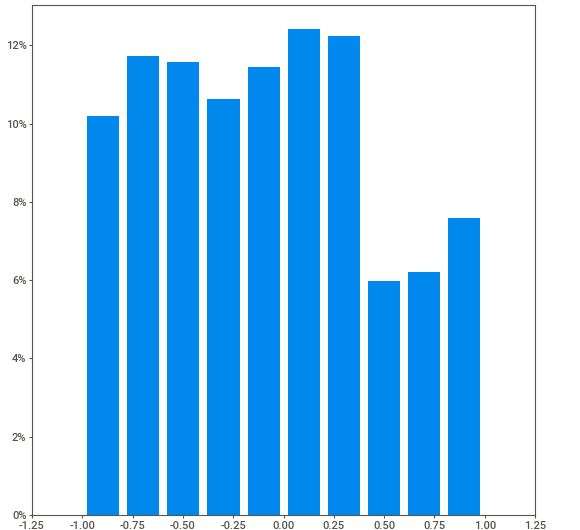
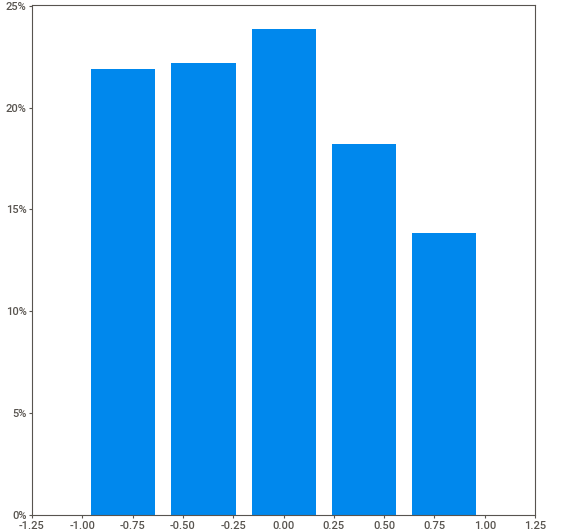
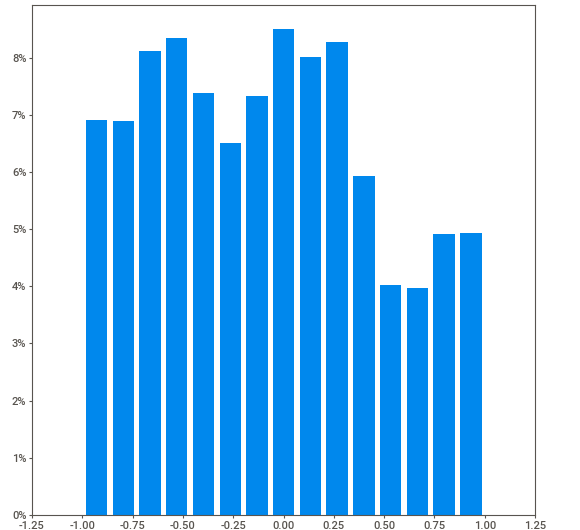
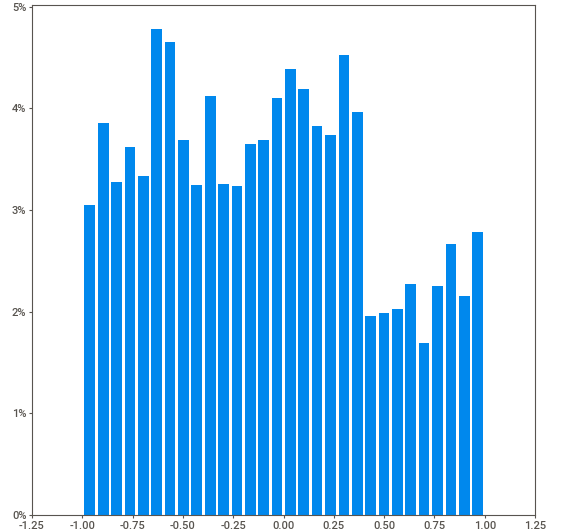
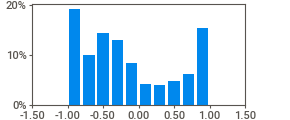
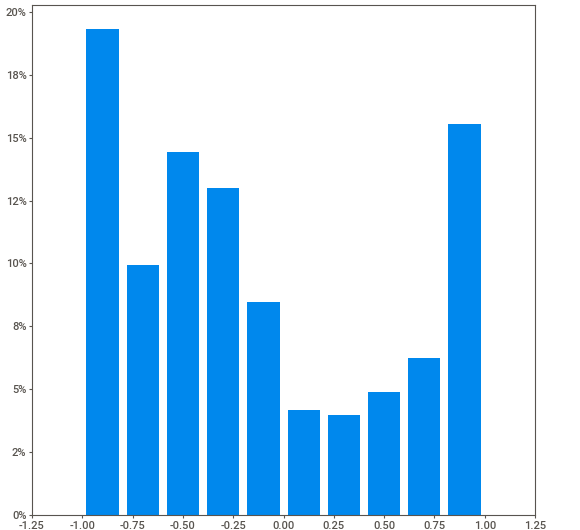
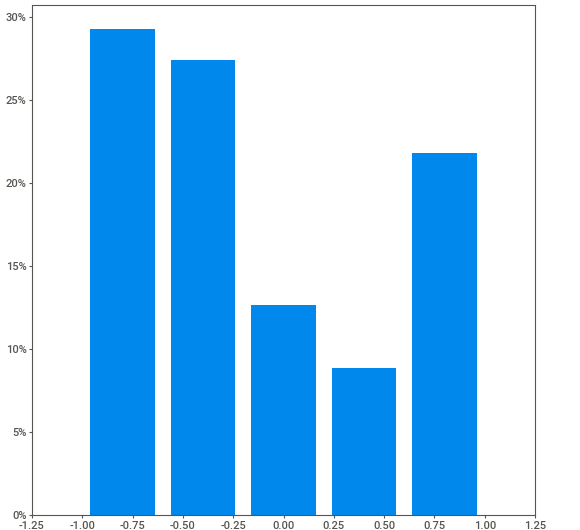
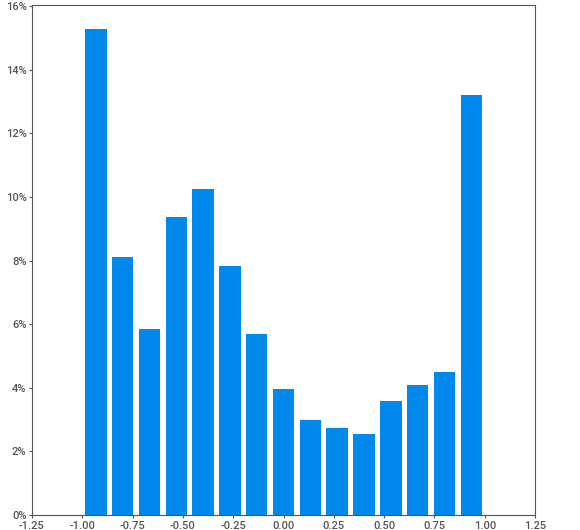
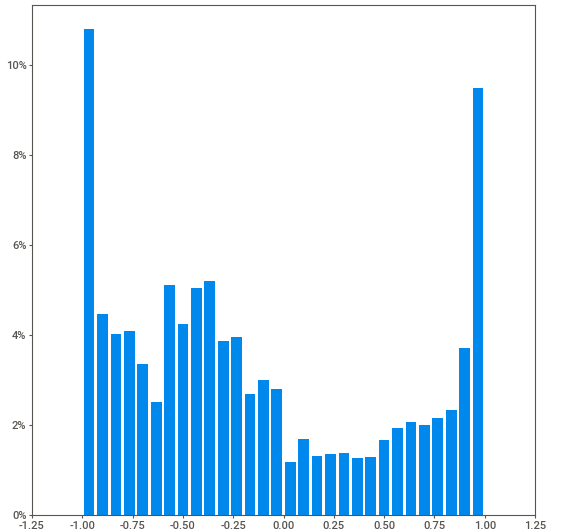
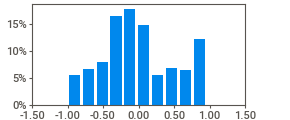
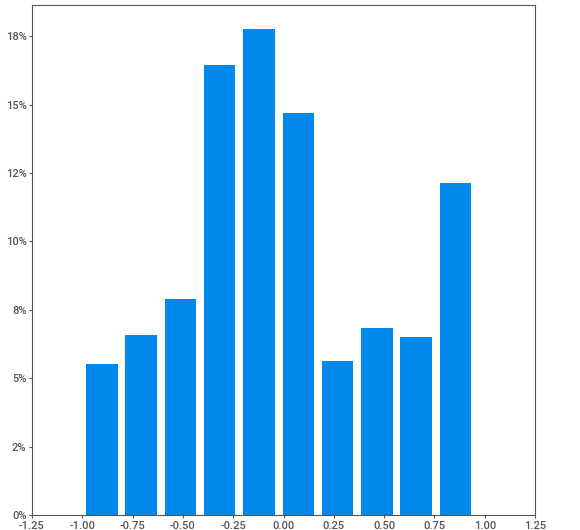
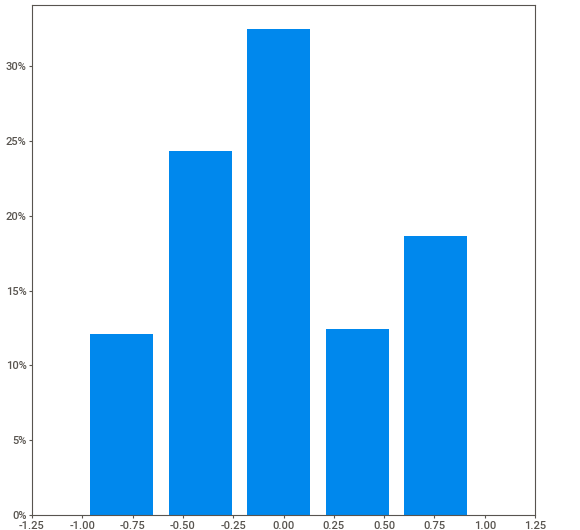
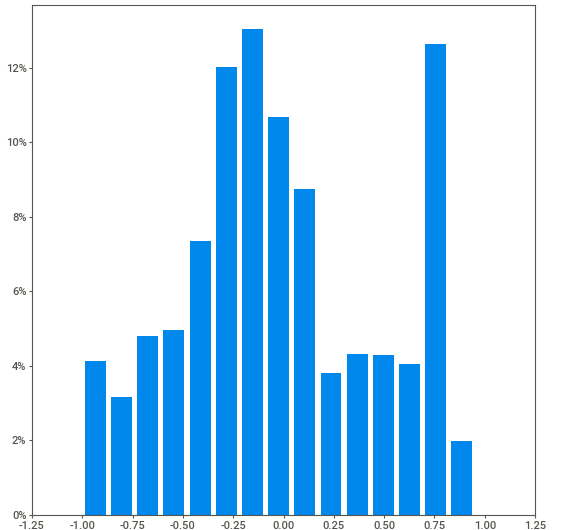
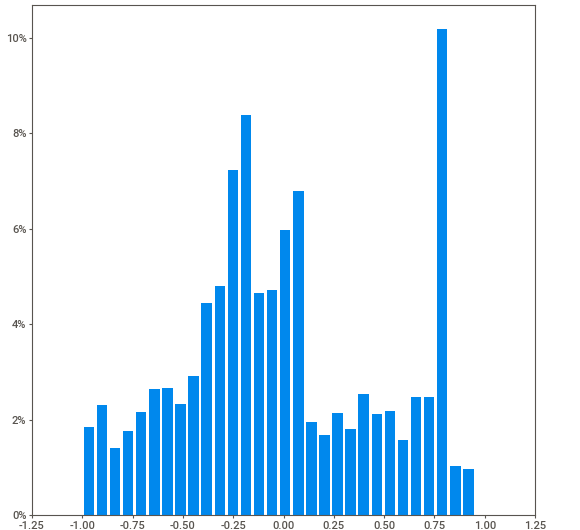
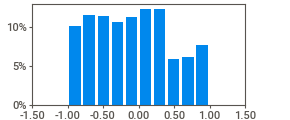
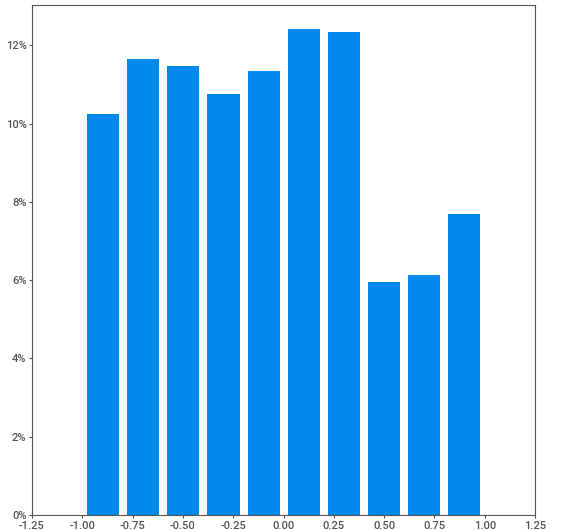
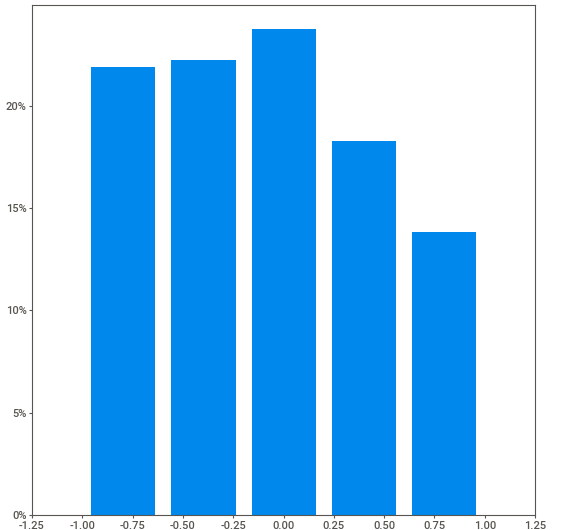
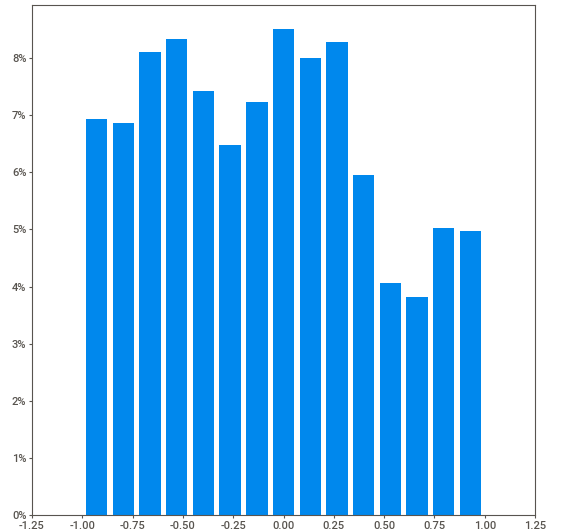
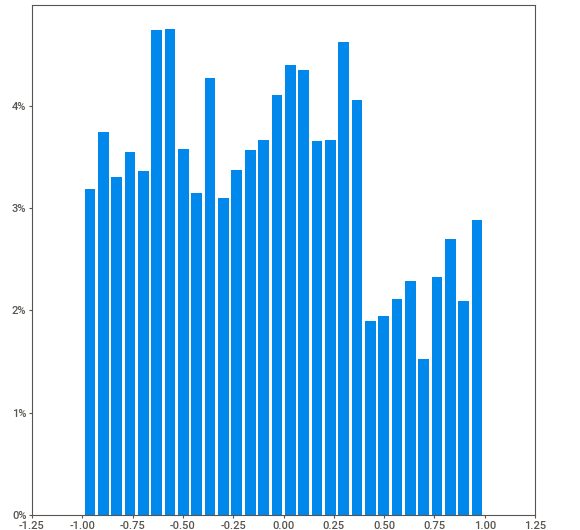
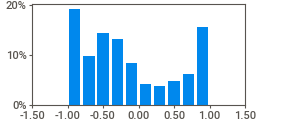
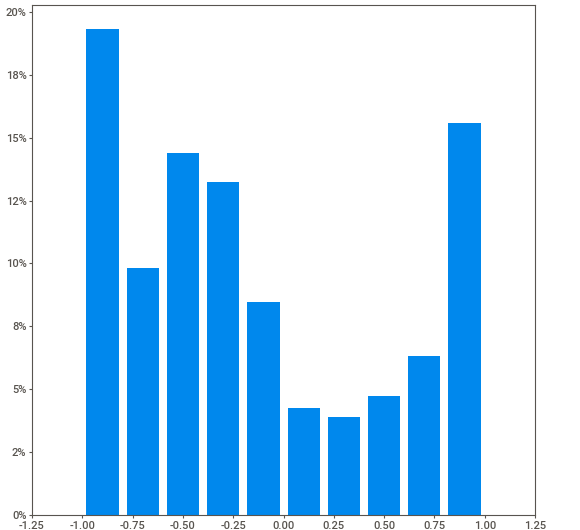
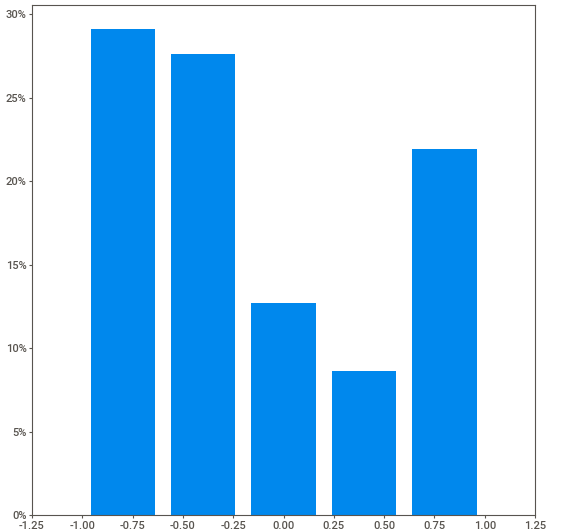
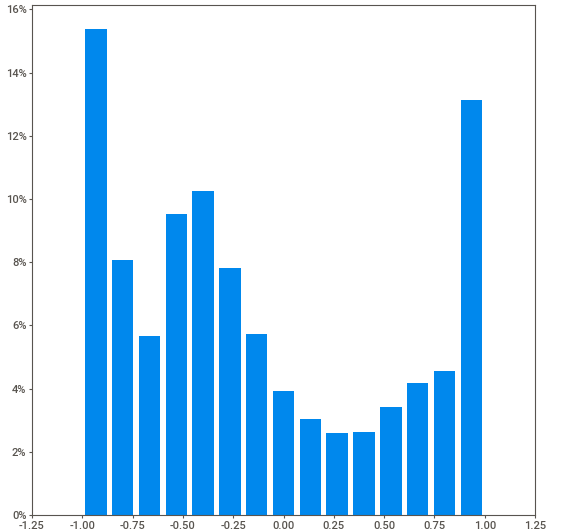
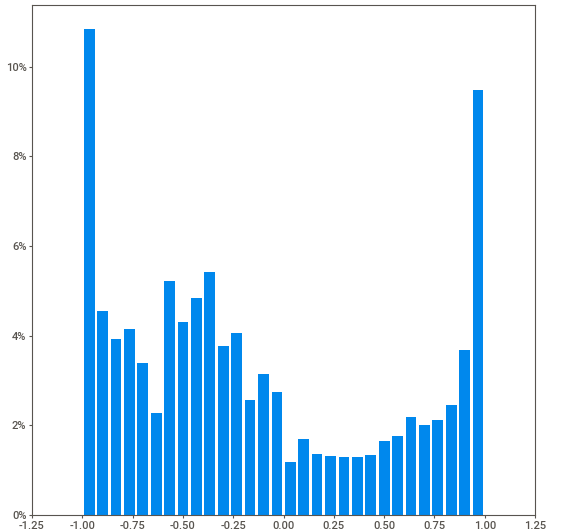
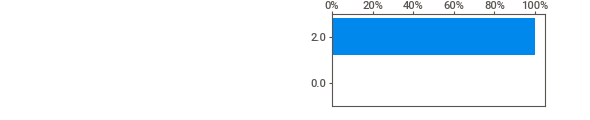
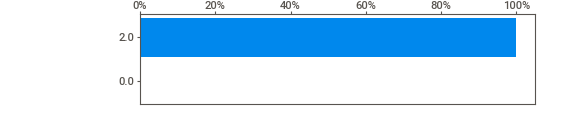
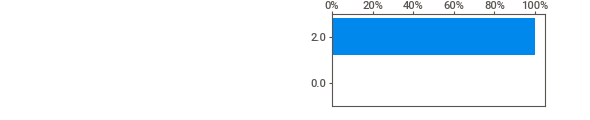
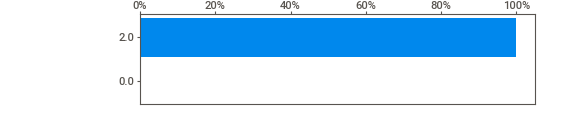
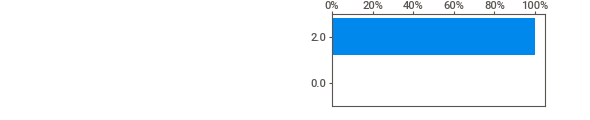
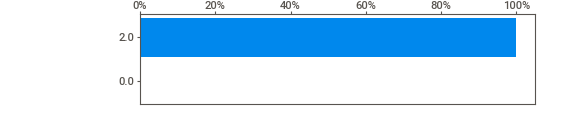
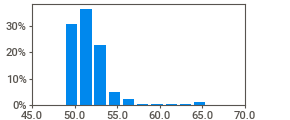
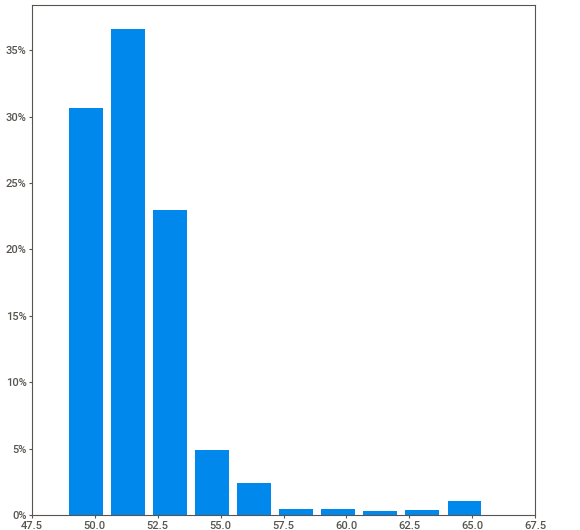
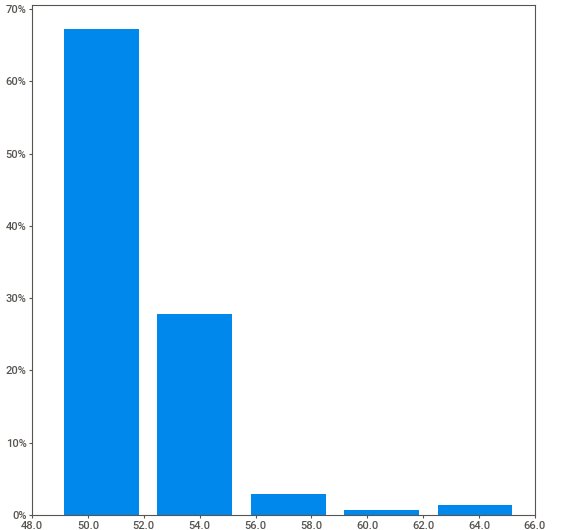
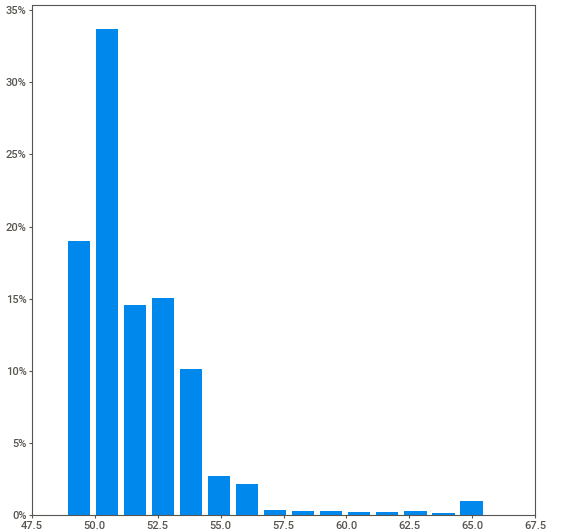
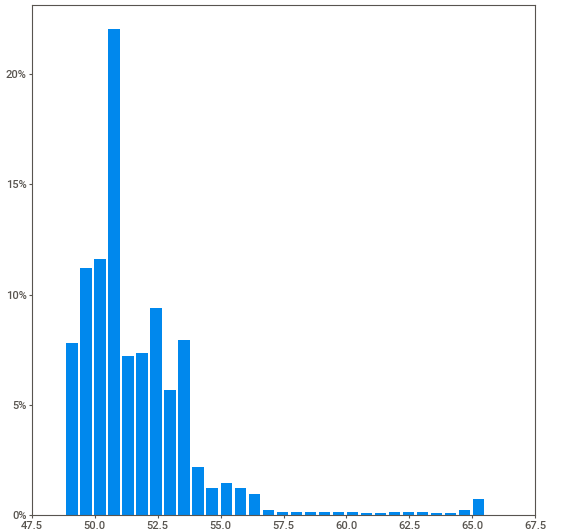
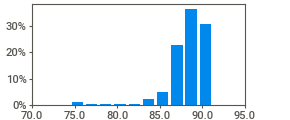
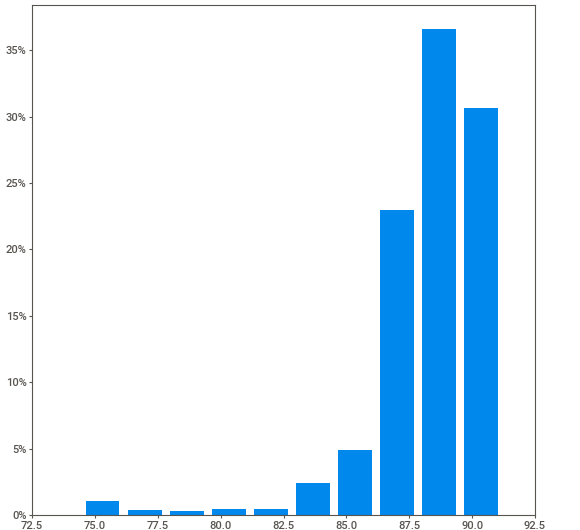
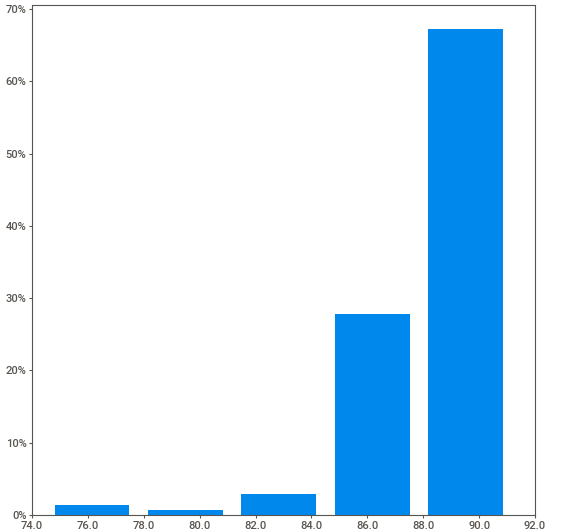
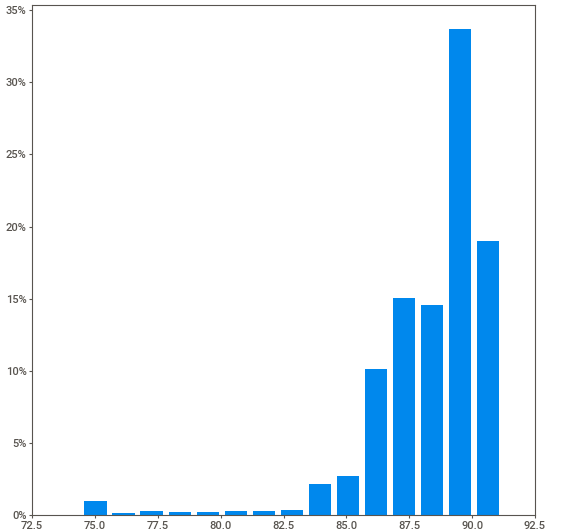
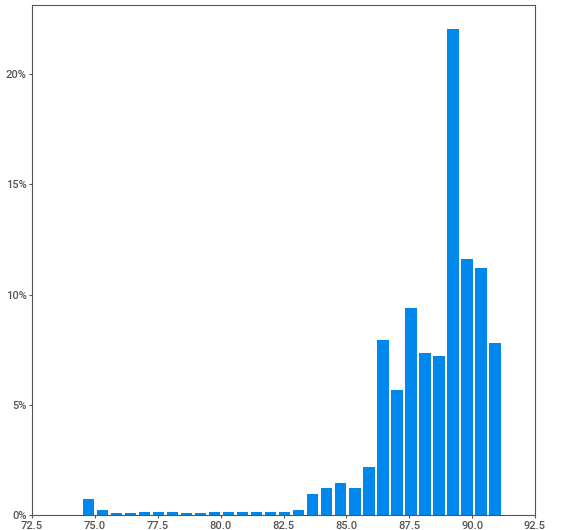
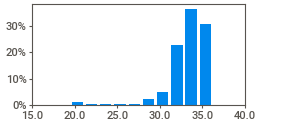
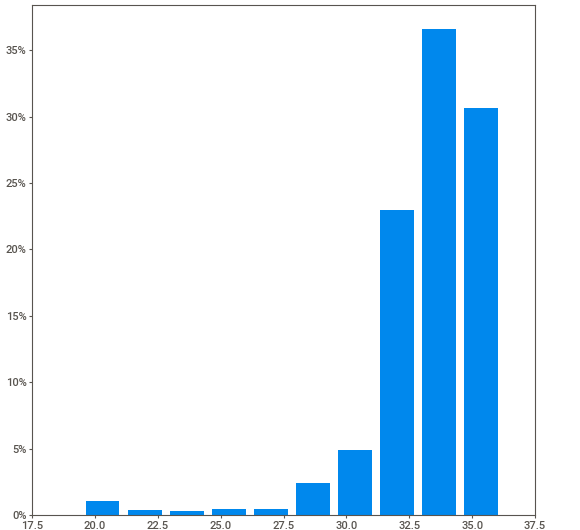
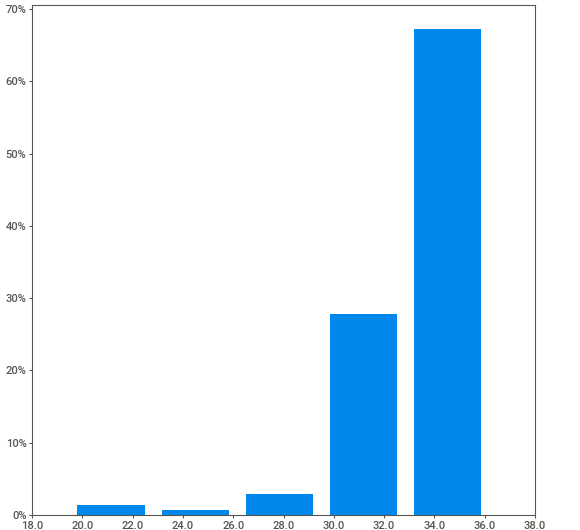
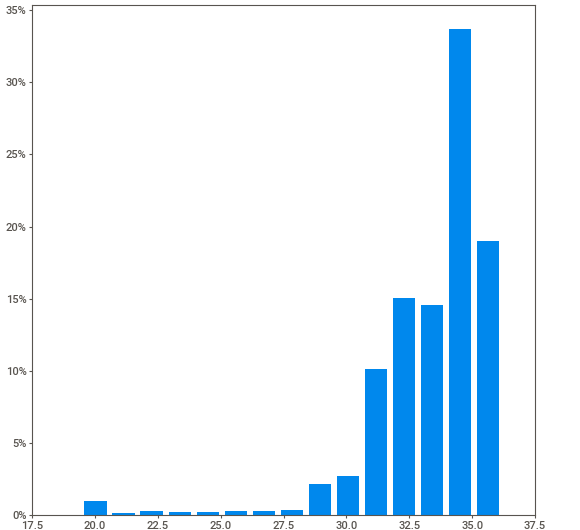
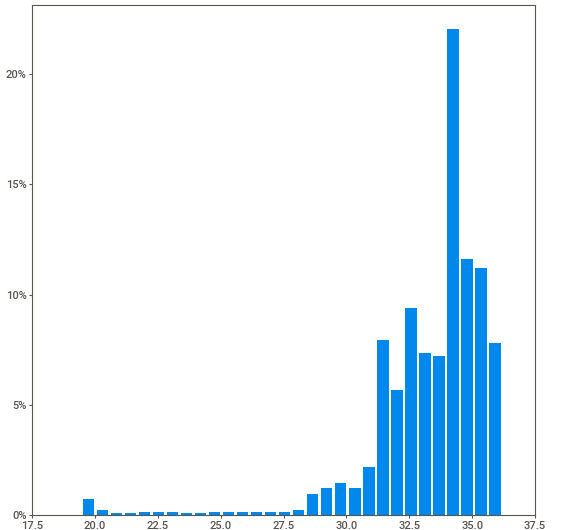

In [25]:
study_alpha_Wildfire_agent_result.blockname("Magnetometer").stats()

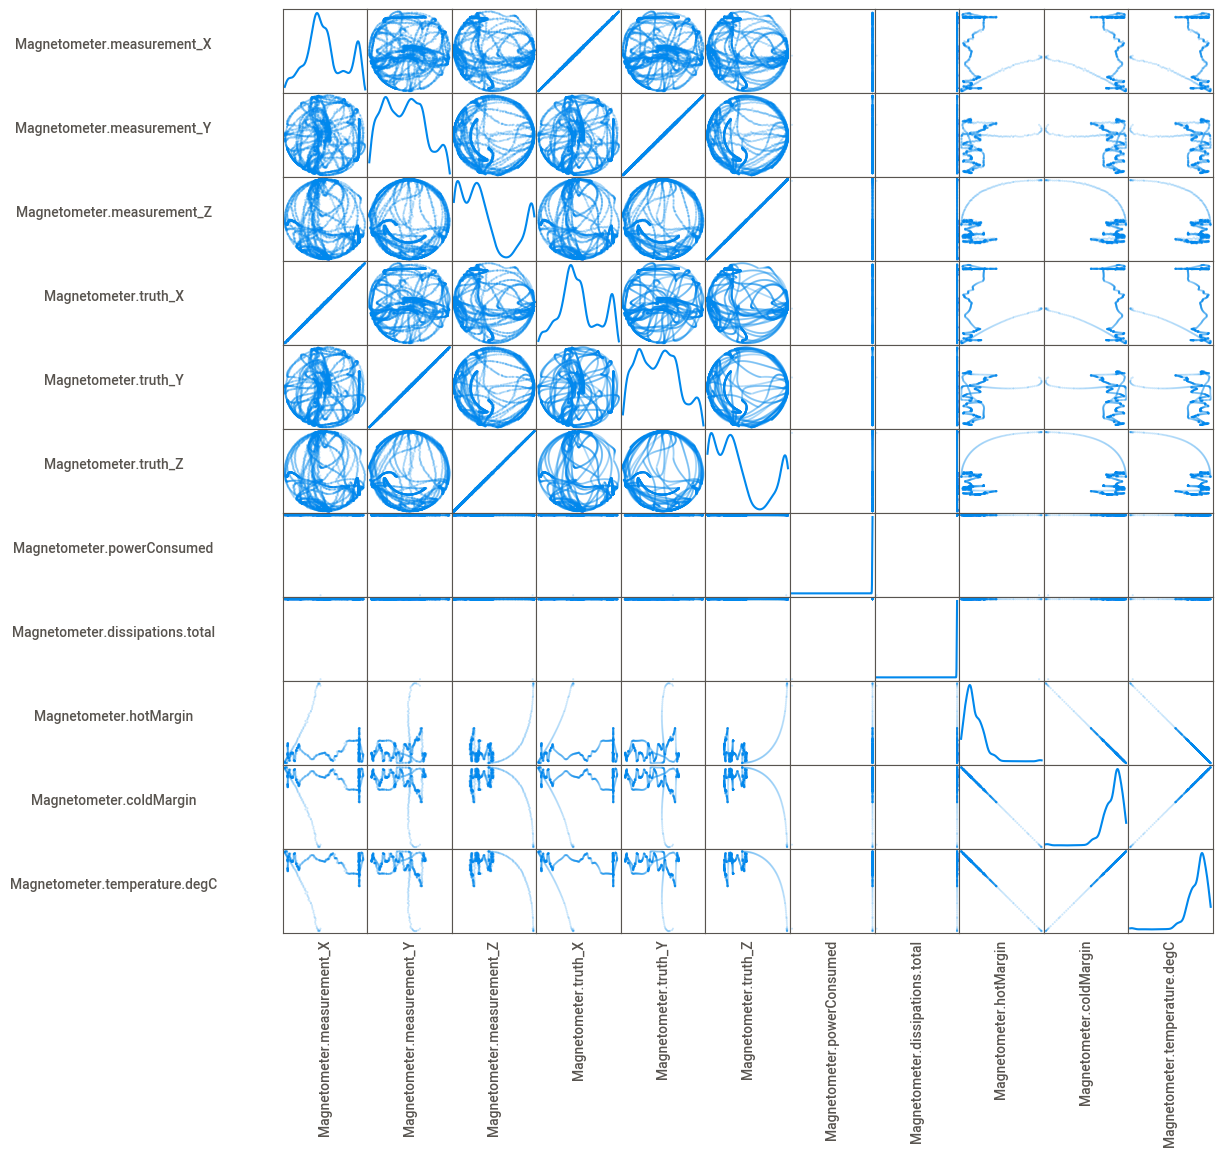

In [26]:
study_alpha_Wildfire_agent_result.blockname("Magnetometer").scatter_matrix()

In [ ]:
plain_first_results =  wildfire_branch.simulation.results_plain(streams=[(wildfire_agent_id,'CDH')])

In [ ]:
with open("first_CDH_results.json", 'w') as writer:
    writer.write(str(plain_first_results))

In [33]:
(study_alpha_Wildfire_agent_result.blockname('Fire: Chichen Itza').summarize())

---------------------------------------------------------------------------
                   Sedaro Simulation Block Result Summary                  
                            'Fire: Chichen Itza'                           
---------------------------------------------------------------------------
🧩 Simulated Modules
    • Command & Data Handling

📋 Variables Available
    • shadow
    • lineOfSight
    • lst
    • range
    • solarAz
    • solarEl
    • agentAzimuth
    • targetAzimuth
    • agentElevation
    • targetElevation
---------------------------------------------------------------------------
❓ Query variables with .<VARIABLE_NAME>
📊 Display all block variables statistics with .stats( output_html=False ) 


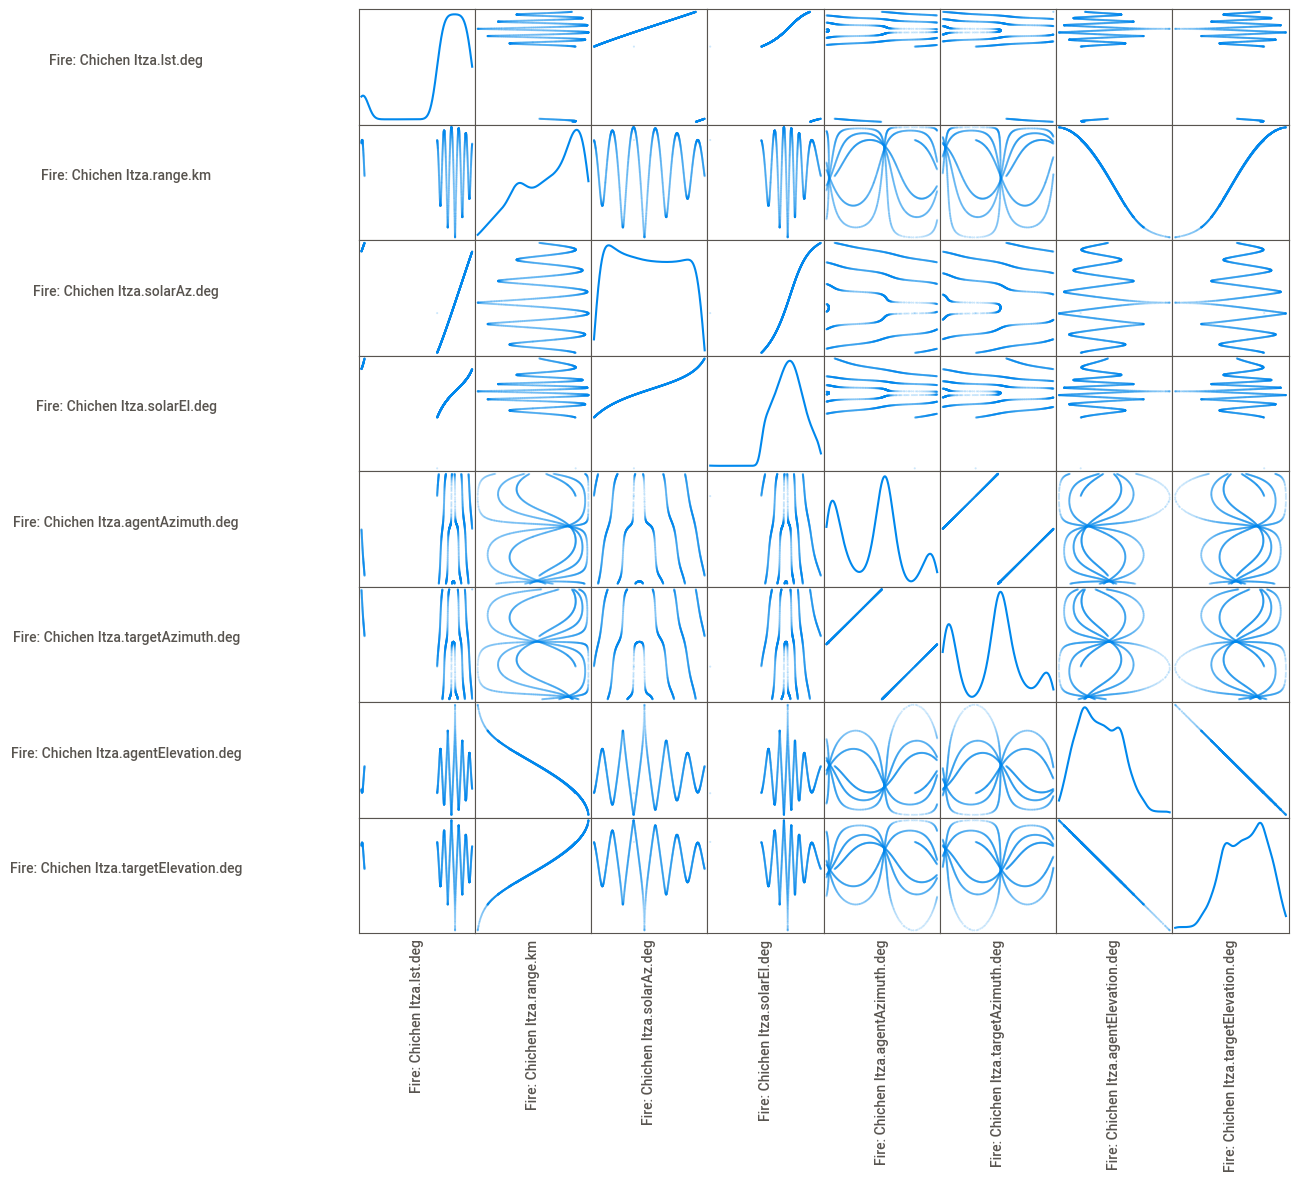

In [36]:
(study_alpha_Wildfire_agent_result.blockname('Fire: Chichen Itza').scatter_matrix())

count         mean          std          min          25%   
range.km  2970.0  11128.50053  3173.198788  2802.924603  9134.327504  \

                   50%           75%           max  
range.km  11600.040755  13470.207223  16274.214959

Feature: range.km                            |██████████| [100%]   00:00 -> (00:00 left)



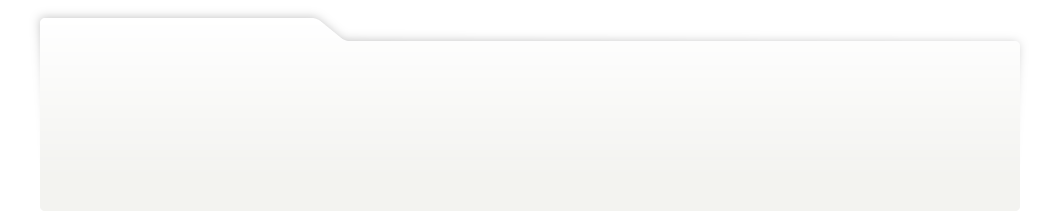
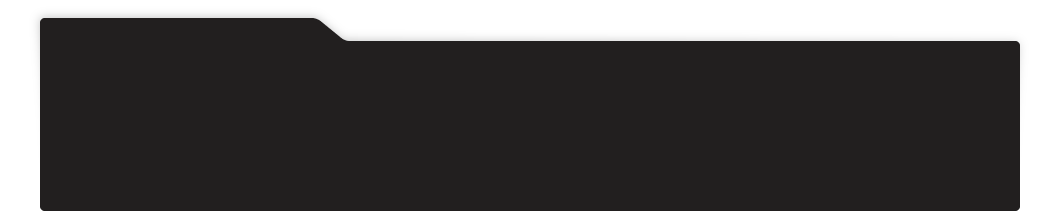
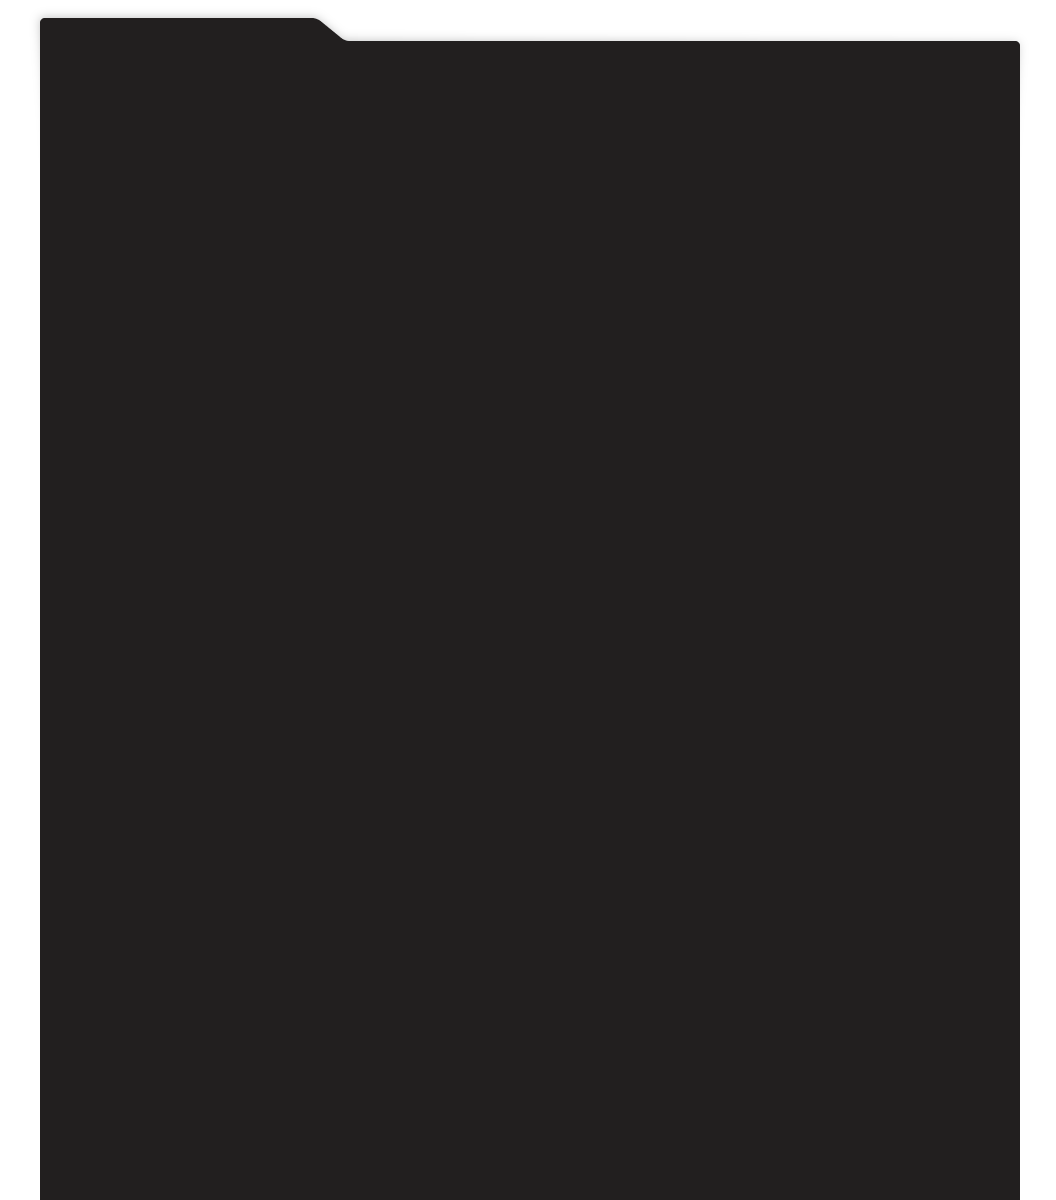
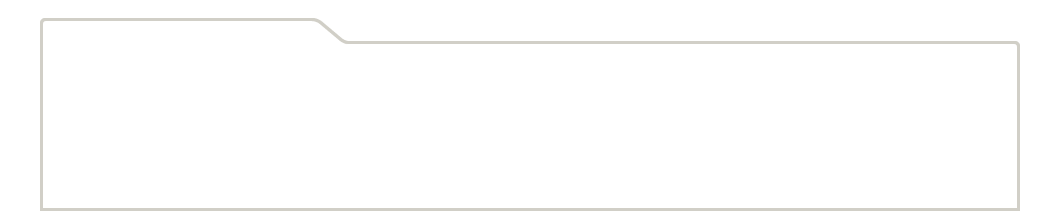
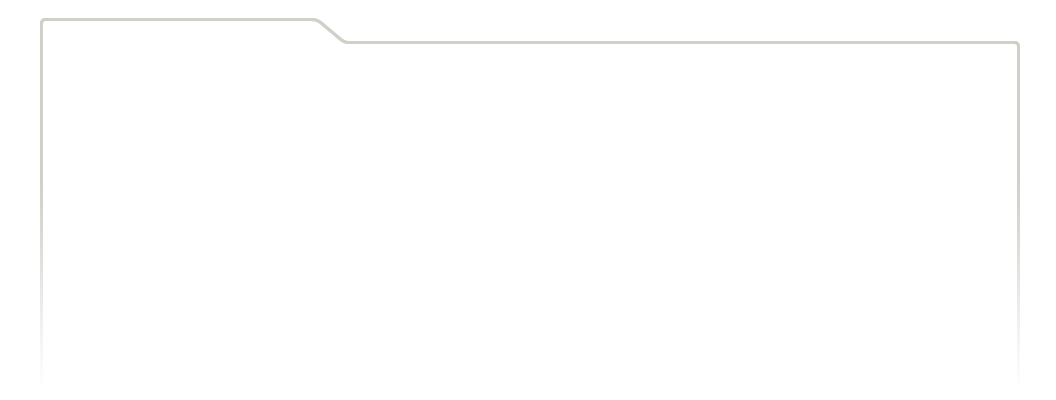
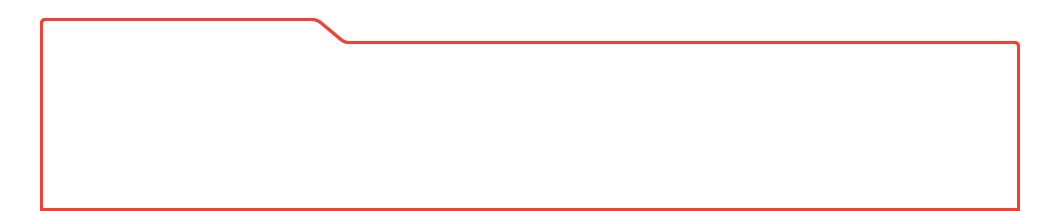
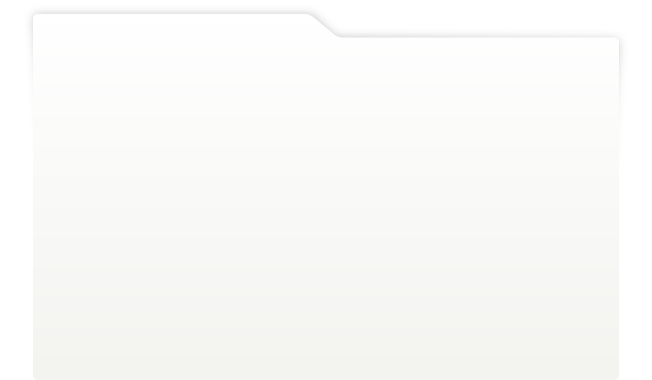
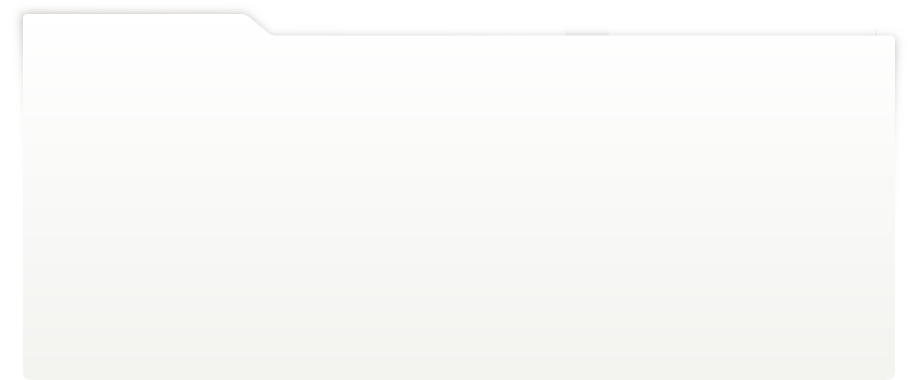
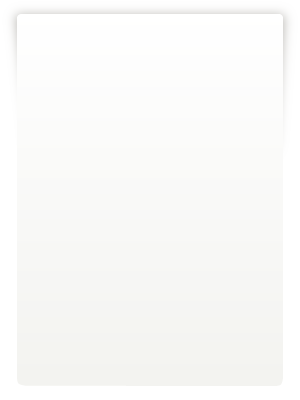
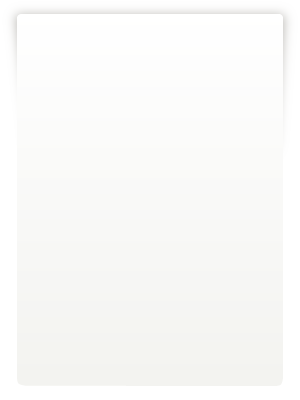
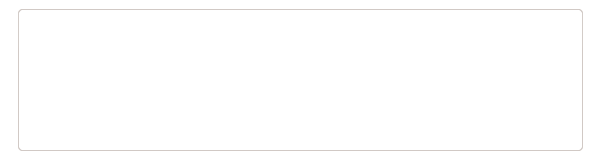
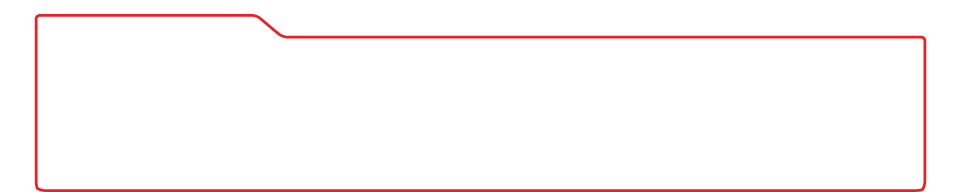
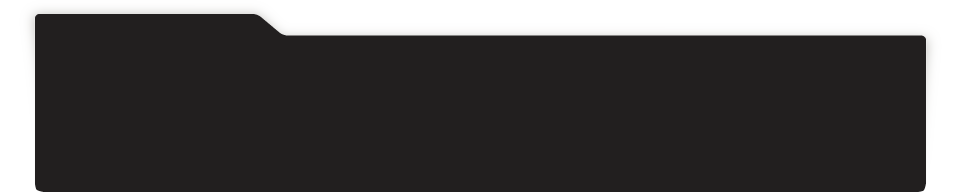
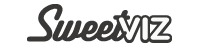
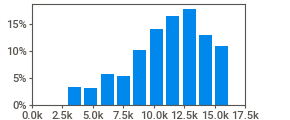
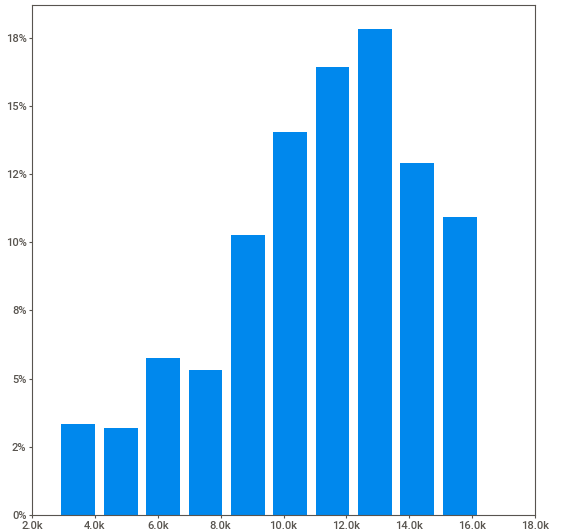
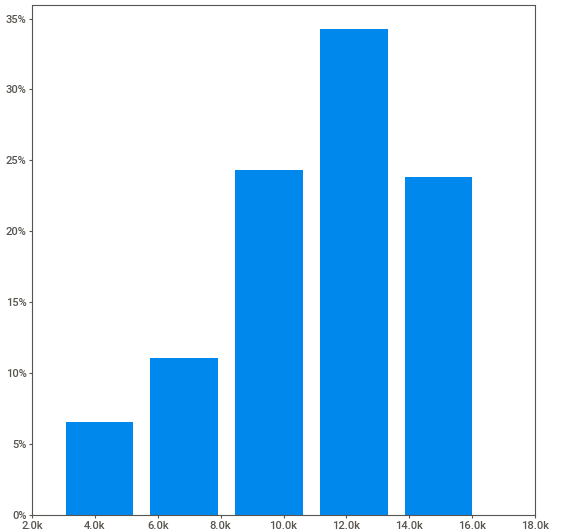
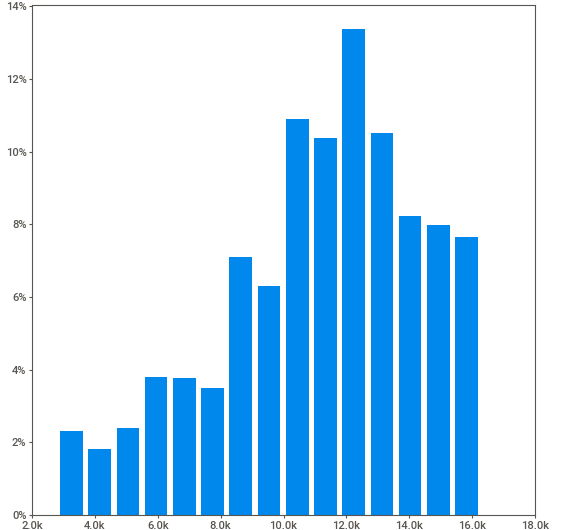
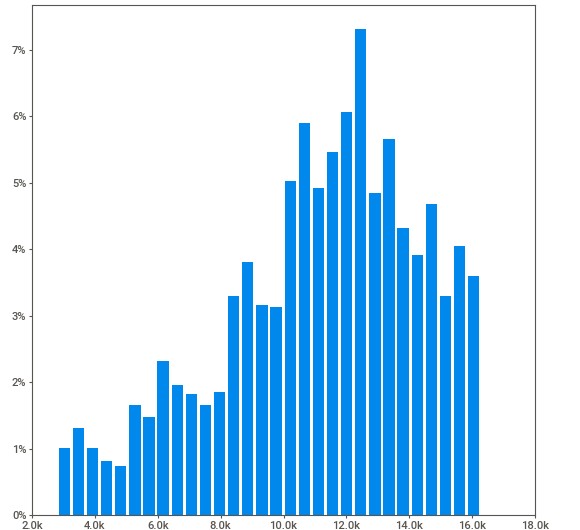

In [35]:
study_alpha_Wildfire_agent_result.blockname('LaserComm-4').range['km'].stats(output_html=False)

In [ ]:
second_results = wildfire_branch.simulation.results(study_job_ids[1],[(wildfire_agent_id,'CDH')])

In [ ]:
second_results.agent('Wildfire').blockname('LaserComm-4').targetElevation['deg'].plot()

In [ ]:
tradespace_studyjob = wildfire_branch.study.results('PK5Z4Mrx8Phf7ZbgGqy4Rr')

In [ ]:
studyjob.summarize()

## Wildfire Monte Carlo Analysis: Understand uncertainty of average pointing error
Parameters to vary:
- Moment of magnetorquers
- Mass of reaction wheels
- Initial position, velocity, and attitude
- Vary random seeds of sensors by changing simulation-wide seen
- 
### Optional: Load shared workspace to skip setup and running the study

#### Tradespace table used
#### Overrides used

### Setup
We'll reuse the scenario_branch_id from the first example but if it was skipped,  Find or make a branch of the wildfire scenaro and record its branch ID value.

#### Table of Agent parameters to vary

#### Determine how to vary the parameters

#### Create Overrides

#### Create Study

### Run Study

### Load Study Results

### Analyze Results

In [ ]:
monte_carlo_overrides_block = wildfire_branch.OverrideSet.create(**monte_carlo_overrides_dict)

# Appendix A: Python client plot/statistics features

## Agent level

## Block level

## Parameter level

## Study level

# Appendix B: fn Signatures


fn Random module Signatures:

## Functions for integers
  - class Randrange(PathFn):
    - fn: Literal["randrange"]
    - start: int | float | str
    - stop:  int | float | str
    - step:  int | float | str 

---

## Functions for sequences
- class Choices(PathFn):
  - fn: Literal["choices"]
  - weights: list
  - population: list   
  - k: int | str
- class Sample(PathFn):
  - fn: Literal["sample"]
  - counts: list
  - population: list
  - k: int

---

## Real-valued distributions
  - class Uniform(PathFn):
    - fn: Literal["uniform"]
    - a: float | int | str
    - b: float | int | str
  - class Triangular(PathFn):
    - fn: Literal["triangular"]
    - low:  int | float | str
    - high: int | float | str
    - mode: int | float | str
  - class Expovariate(PathFn):
    - fn: Literal["expovariate"]
    - lambd: float | str
  - class GammaVariate(PathFn):
    - fn: Literal["gammavariate"]
    - alpha: int | float | str
    - beta:  int | float | str
  - class Gauss(PathFn):
    - fn: Literal["gauss"]
    - mu:    int | float | str
    - sigma: int | float | str
  - class NormalVariate(PathFn):
    - fn: Literal["normalvariate"]
    - mu:    int | float | str
    - sigma: int | float | str
  - class LogNormVariate(PathFn):
    - fn: Literal["lognormvariate"]
    - mu:    int | float | str
    - sigma: int | float | str
  - class VonmisesVariate(PathFn):
    - fn: Literal["vonmisesvariate"]
    - mu:    int | float | str
    - kappa: int | float | str
  - class ParetoVariate(PathFn):
    - fn: Literal["paretovariate"]
    - alpha: int | float | str    
  - class WeibullVariate(PathFn):
    - fn: Literal["weibullvariate"]
    - alpha: int | float | str
    - beta:  int | float | str

# Appendix C: Class methods for the scenario_branch.study Class, along with it's support classes

## Study Class
| Class Method | Arguments  | Returns | Description |
| :-: | :-: | :-: | :- | 
| start | ( iterations: int ) | StudyHandle | Starts study corresponding to the respective Sedaro Scenario Branch id. |
| status | ( job_id: str = None ) | StudyHandle |  Refreshes the local study status. |
| terminate | ( job_id: str = None ) | StudyHandle | Terminate latest running simulation job corresponding to the respective Sedaro Scenario Branch id. |
|  |  |  | If a `job_id` is provided, that simulation job will be terminated rather than the latest. |
| |
| results | (job_id: str = None) | StudyResult | Query latest scenario study result. If a `job_id` is passed, query for corresponding sim results rather than latest. |
| results_poll | ( job_id: str = None, retry_interval: int = 2) | StudyResult | Query latest scenario study result and wait for sim to finish if it's running. | 
| | | | If a `job_id` is passed, query for corresponding study results rather than latest. See `results` method for details on using the `streams` kwarg. |
| |
| stats_results | () | StudyStatsResult | Retuens a 'StudyStatsResult' instance of Statistics based on the study result data |

---

## StudyHandle
By default, this class will lazily load simulation results as requested
and cache them in-memory. Different caching options can be enabled with
the .set_cache method.

| Class Method | Arguments  | Returns | Description |
| :-: | :-: | :-: | :- | 
| get | (key, default=None) | StudyHandle | Returns a Study handle with the given key |
| status | (err_if_empty: bool = True) | StudyHandle | Refreshes the local study status. |
| terminate | () | StudyHandle | Terminate the running study. |
| |
| results | () | StudyResults | Query study results. |
| results_poll | (retry_interval: int = 2) | StudyResults | Query study results but wait for sim to finish if it's running. See `results` method for details on using the `streams` kwarg. |
| |
| stats_results | () | StudyStatsResult | Returns a StudyStatResult object |

---

## StudyResult
| Class Method | Arguments  | Returns | Description |
| :-: | :-: | :-: | :- | 
| id | () | int | Returns the id of the StudyResult Object |
| branch | () | str | Returns the branch id of the StudyResult Object |
| scenario_hash | () | str | Returns a unique hash |
| status | () | str | xx |
| date_created | () | datetime | xx |
| date_modified | () | datetime | xx |
| job_ids | () | List[int] | Returns a list of SimJob id's created by the Study.start method |
| iterations | () | int | Returns the number of SimJobs created by the Study.start method |
| set_cache | (cache: bool = True, cache_dir: str = None) | None | Set caching options for this study result. |
| | | | cache: Boolean option to turn caching on or off. |
| | | | cache_dir: Path to a directory for on-disk caching. |
| result | (id_: str, streams: Optional[List[Tuple[str, ...]]] = None) | SimulationResult | Query results for a particular simulation. |
| clear_cache | () | None | Clears the cache files in the cache_dir |
| summarize | () | None | Summarize these results in the console.' |

---

## StudyStatsResult                                                                                                        
| Class Method | Arguments  | Returns | Description |
| :-: | :-: | :-: | :- | 
| id | () | int | Returns the id of the StudyResult Object |
| branch | () | str | Returns the branch id of the StudyResult Object |
| scenario_hash | () | str | Returns a unique hash |
| status | () | str | xx |
| date_created | () | datetime | xx |
| date_modified | () | datetime | xx |
| job_ids | () | List[int] | Returns a list of SimJob id's created by the Study.start method |
| iterations | () | int | Returns the number of SimJobs created by the Study.start method |
| set_cache | (cache: bool = True, cache_dir: str = None) | None | Set caching options for this study result. |
| | | | cache: Boolean option to turn caching on or off. |
| | | | cache_dir: Path to a directory for on-disk caching. |
| result | (id_: str, streams: Optional[List[Tuple[str, ...]]] = None) | SimulationResult | Query results for a particular simulation. |
| clear_cache | () | None | Clears the cache files in the cache_dir |
| summarize | () | None | Summarize these results in the console.' |
| stats_results | (_ids=None ) | dict[simjob_id, pandas.dataframe] | Packages the sim results into a dictory of simjob_id to sim results as a pandas dataframe |
| xx | xx | xx | xx |
| xx | xx | xx | xx |
| xx | xx | xx | xx |